# PRCP-1023-JohnsHopkinsCovid19 - Covid Prediction

## Team ID: PTID-CDS-APR21-1119 

This project includes datasets of Covid19. We are having 3 datasets of Recovered, Confirmed and Death. Our target of this project is to analyse the impact of covid19 throughout the world and also to predict the confirmed,recovered and death for 5 countries which is having higher number of Active cases. 

Looking into the raw data set , we see that its time series dataset.


# 1.Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import plotly.express as px
import plotly.graph_objs as go

from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings("ignore")
from fbprophet import Prophet
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error,mean_absolute_percentage_error

In [2]:
#df_confirmed = pd.read_csv(r"C:\Users\Hp\Desktop\Intership\covid-19\dataset\time_series_covid19_confirmed_global.csv")
#df_death = pd.read_csv(r"C:\Users\Hp\Desktop\Intership\covid-19\dataset\time_series_covid19_deaths_global.csv")
#df_recovered = pd.read_csv(r"C:\Users\Hp\Desktop\Intership\covid-19\dataset\time_series_covid19_recovered_global.csv")

df_confirmed = pd.read_csv('time_series_covid19_confirmed_global.csv', skipinitialspace=True)
df_death = pd.read_csv('time_series_covid19_deaths_global.csv', skipinitialspace=True)
df_recovered = pd.read_csv('time_series_covid19_recovered_global.csv', skipinitialspace=True)

-> df_confirmed,df_death,df_recovered are different dataframes so we have to merge these data frame in order to do timeseries analysis

In [3]:
# Changing name for our easiness

df_confirmed.rename(columns={
    'Province/State' : 'state',
    'Country/Region': 'Country'
},inplace=True)

df_death.rename(columns={
    'Province/State' : 'state',
    'Country/Region': 'Country'
},inplace=True)

df_recovered.rename(columns={
    'Province/State' : 'state',
    'Country/Region': 'Country'
},inplace=True)

In [4]:
df_confirmed.count(),df_death.count(),df_recovered.count()

(state       81
 Country    266
 Lat        266
 Long       266
 1/22/20    266
           ... 
 9/17/20    266
 9/18/20    266
 9/19/20    266
 9/20/20    266
 9/21/20    266
 Length: 248, dtype: int64,
 state       81
 Country    266
 Lat        266
 Long       266
 1/22/20    266
           ... 
 9/17/20    266
 9/18/20    266
 9/19/20    266
 9/20/20    266
 9/21/20    266
 Length: 248, dtype: int64,
 state       67
 Country    253
 Lat        253
 Long       253
 1/22/20    253
           ... 
 9/17/20    253
 9/18/20    253
 9/19/20    253
 9/20/20    253
 9/21/20    253
 Length: 248, dtype: int64)

-> While going through the dataset the df_recovered is having lesser number of rows. 
-> This is confirmed by observing recovered dataset which have on state count of only 67, but other dataset has 81 count..


# 2.Merging confirmed,death and recovered

-> first of all we have to convert that dates into a single column,converting all dates columns to date rows.. For this we are using melt function.

In [5]:
dates = df_confirmed.columns[4:]
df_con_new = pd.melt(df_confirmed,
                     id_vars=['state', 'Country', 'Lat', 'Long'], 
                     value_vars=dates, 
                     var_name='Date', 
                     value_name='Confirmed')

df_death_new = pd.melt(df_death,
                      id_vars=['state', 'Country', 'Lat', 'Long'], 
                      value_vars=dates, 
                      var_name='Date', 
                      value_name='Deaths')

df_recovered_new = pd.melt(df_recovered,
                          id_vars=['state', 'Country', 'Lat', 'Long'], 
                          value_vars=dates, 
                          var_name='Date', 
                          value_name='Recovered')

# 3.Data cleaning

#### 1.Confirmed cases

In [6]:
df_con_new

state             Country        Lat       Long     Date  Confirmed
0       NaN         Afghanistan  33.939110  67.709953  1/22/20          0
1       NaN             Albania  41.153300  20.168300  1/22/20          0
2       NaN             Algeria  28.033900   1.659600  1/22/20          0
3       NaN             Andorra  42.506300   1.521800  1/22/20          0
4       NaN              Angola -11.202700  17.873900  1/22/20          0
...     ...                 ...        ...        ...      ...        ...
64899   NaN  West Bank and Gaza  31.952200  35.233200  9/21/20      36151
64900   NaN      Western Sahara  24.215500 -12.885800  9/21/20         10
64901   NaN               Yemen  15.552727  48.516388  9/21/20       2028
64902   NaN              Zambia -13.133897  27.849332  9/21/20      14175
64903   NaN            Zimbabwe -19.015438  29.154857  9/21/20       7683

[64904 rows x 6 columns]

In [7]:
# Removing ship from Confirmed Dataset
ship_confirmed = df_con_new[df_con_new.Lat == 0]
df_con_new = df_con_new[df_con_new.Lat != 0]
df_con_new.shape,ship_confirmed.shape

((63928, 6), (976, 6))

-> Sucessfully seprated ships from Confirmed dataset,as these are not real provinces/states

--> after observing all 3 dats set, Country canada have only row in recovered, but multiple in confirmed and deaths dataset.
--> inorder to maintain concistancy in all 3 sets, we have convert multiple provinces to of canada into single province.

In [8]:

# seprating canada from dataset for data cleaning 

df_nocanada = df_con_new[df_con_new.Country != 'Canada']
df_canada = df_con_new[df_con_new.Country == 'Canada']

In [9]:
df_nocanada.shape,df_canada.shape

((61000, 6), (2928, 6))

In [10]:
# removing provinces from canada to avoid mismatch during merging

df_canada = df_canada.groupby(['Date','Country'],as_index=False).agg({'Confirmed':'sum'})

In [11]:
df_canada

Date Country  Confirmed
0    1/22/20  Canada          0
1    1/23/20  Canada          0
2    1/24/20  Canada          0
3    1/25/20  Canada          0
4    1/26/20  Canada          1
..       ...     ...        ...
239   9/5/20  Canada     133498
240   9/6/20  Canada     133877
241   9/7/20  Canada     134282
242   9/8/20  Canada     135744
243   9/9/20  Canada     136122

[244 rows x 3 columns]

--> successfully removed provinces

In [12]:
#merge into one dataset as confirmed
df_con_final = pd.merge(df_nocanada,df_canada,
                       on =['Date','Country','Confirmed'],
                       how = 'outer')


In [13]:
df_con_final

state      Country       Lat       Long     Date  Confirmed
0       NaN  Afghanistan  33.93911  67.709953  1/22/20          0
1       NaN      Albania  41.15330  20.168300  1/22/20          0
2       NaN      Algeria  28.03390   1.659600  1/22/20          0
3       NaN      Andorra  42.50630   1.521800  1/22/20          0
4       NaN       Angola -11.20270  17.873900  1/22/20          0
...     ...          ...       ...        ...      ...        ...
61239   NaN       Canada       NaN        NaN   9/5/20     133498
61240   NaN       Canada       NaN        NaN   9/6/20     133877
61241   NaN       Canada       NaN        NaN   9/7/20     134282
61242   NaN       Canada       NaN        NaN   9/8/20     135744
61243   NaN       Canada       NaN        NaN   9/9/20     136122

[61244 rows x 6 columns]

In [13]:
# data type convertionof date column.
df_con_final.Date = pd.to_datetime(df_con_final.Date)

In [14]:
#sort the dataset
df_con_final.sort_values(['Date','Country'],inplace=True)
df_con_final

state             Country        Lat       Long       Date  Confirmed
0       NaN         Afghanistan  33.939110  67.709953 2020-01-22          0
1       NaN             Albania  41.153300  20.168300 2020-01-22          0
2       NaN             Algeria  28.033900   1.659600 2020-01-22          0
3       NaN             Andorra  42.506300   1.521800 2020-01-22          0
4       NaN              Angola -11.202700  17.873900 2020-01-22          0
...     ...                 ...        ...        ...        ...        ...
60995   NaN  West Bank and Gaza  31.952200  35.233200 2020-09-21      36151
60996   NaN      Western Sahara  24.215500 -12.885800 2020-09-21         10
60997   NaN               Yemen  15.552727  48.516388 2020-09-21       2028
60998   NaN              Zambia -13.133897  27.849332 2020-09-21      14175
60999   NaN            Zimbabwe -19.015438  29.154857 2020-09-21       7683

[61244 rows x 6 columns]

In [15]:
#re-indexing
df_con_final.reset_index(drop=True,inplace=True)
df_con_final.index.name = 'Id'
df_con_final

state             Country        Lat       Long       Date  Confirmed
Id                                                                         
0       NaN         Afghanistan  33.939110  67.709953 2020-01-22          0
1       NaN             Albania  41.153300  20.168300 2020-01-22          0
2       NaN             Algeria  28.033900   1.659600 2020-01-22          0
3       NaN             Andorra  42.506300   1.521800 2020-01-22          0
4       NaN              Angola -11.202700  17.873900 2020-01-22          0
...     ...                 ...        ...        ...        ...        ...
61239   NaN  West Bank and Gaza  31.952200  35.233200 2020-09-21      36151
61240   NaN      Western Sahara  24.215500 -12.885800 2020-09-21         10
61241   NaN               Yemen  15.552727  48.516388 2020-09-21       2028
61242   NaN              Zambia -13.133897  27.849332 2020-09-21      14175
61243   NaN            Zimbabwe -19.015438  29.154857 2020-09-21       7683

[61244 rows x 6 columns]

-> Data cleaning completed in confirmed dataset and saved in df_con_final

#### 2.Death cases

In [16]:
# Removing ship from Confirmed Dataset
ship_death = df_death_new[df_death_new.Lat == 0]
df_death_new = df_death_new[df_death_new.Lat != 0]
df_death_new.shape,ship_death.shape

((63928, 6), (976, 6))

-> sucessully seprated ships from death dataset

In [17]:
# seprating canada from dataset for data cleaning

df_nocanada = df_death_new[df_death_new.Country != 'Canada']
df_canada = df_death_new[df_death_new.Country == 'Canada']
df_nocanada.shape,df_canada.shape

((61000, 6), (2928, 6))

In [18]:
# removing provinces from canada to avoid mismatch during merging

df_canada = df_canada.groupby(['Date','Country'],as_index=False).agg({'Deaths':'sum'})

In [19]:
df_canada

Date Country  Deaths
0    1/22/20  Canada       0
1    1/23/20  Canada       0
2    1/24/20  Canada       0
3    1/25/20  Canada       0
4    1/26/20  Canada       0
..       ...     ...     ...
239   9/5/20  Canada    9191
240   9/6/20  Canada    9193
241   9/7/20  Canada    9195
242   9/8/20  Canada    9202
243   9/9/20  Canada    9203

[244 rows x 3 columns]

In [20]:
df_death_final = pd.merge(df_nocanada,df_canada,
                       on =['Date','Country','Deaths'],
                       how = 'outer')

In [21]:
df_death_final

state      Country       Lat       Long     Date  Deaths
0       NaN  Afghanistan  33.93911  67.709953  1/22/20       0
1       NaN      Albania  41.15330  20.168300  1/22/20       0
2       NaN      Algeria  28.03390   1.659600  1/22/20       0
3       NaN      Andorra  42.50630   1.521800  1/22/20       0
4       NaN       Angola -11.20270  17.873900  1/22/20       0
...     ...          ...       ...        ...      ...     ...
61239   NaN       Canada       NaN        NaN   9/5/20    9191
61240   NaN       Canada       NaN        NaN   9/6/20    9193
61241   NaN       Canada       NaN        NaN   9/7/20    9195
61242   NaN       Canada       NaN        NaN   9/8/20    9202
61243   NaN       Canada       NaN        NaN   9/9/20    9203

[61244 rows x 6 columns]

In [22]:
df_death_final.sort_values(['Date','Country'],inplace=True)

In [23]:
df_death_final.Date = pd.to_datetime(df_death_final.Date)

In [24]:
df_death_final.reset_index(drop=True,inplace=True)
df_death_final

state             Country        Lat       Long       Date  Deaths
0       NaN         Afghanistan  33.939110  67.709953 2020-01-22       0
1       NaN             Albania  41.153300  20.168300 2020-01-22       0
2       NaN             Algeria  28.033900   1.659600 2020-01-22       0
3       NaN             Andorra  42.506300   1.521800 2020-01-22       0
4       NaN              Angola -11.202700  17.873900 2020-01-22       0
...     ...                 ...        ...        ...        ...     ...
61239   NaN  West Bank and Gaza  31.952200  35.233200 2020-09-09     192
61240   NaN      Western Sahara  24.215500 -12.885800 2020-09-09       1
61241   NaN               Yemen  15.552727  48.516388 2020-09-09     576
61242   NaN              Zambia -13.133897  27.849332 2020-09-09     300
61243   NaN            Zimbabwe -19.015438  29.154857 2020-09-09     222

[61244 rows x 6 columns]

In [25]:
Death = df_death_final.Deaths
Death.index.name = 'Id'
Death

Id
0          0
1          0
2          0
3          0
4          0
        ... 
61239    192
61240      1
61241    576
61242    300
61243    222
Name: Deaths, Length: 61244, dtype: int64

-> sucessfully cleaned

### 3.Recovered

In [26]:
ship_recovered = df_recovered_new[df_recovered_new.Lat == 0]
df_recovered_final = df_recovered_new[df_recovered_new.Lat != 0]
df_recovered_final.shape, ship_recovered.shape

((61244, 6), (488, 6))

In [27]:
#datatype conversion
df_recovered_final.Date = pd.to_datetime(df_recovered_final.Date)

In [28]:
#reset index
df_recovered_final.reset_index(drop=True,inplace=True)

In [29]:
Recovered = df_recovered_final.Recovered
Recovered.index.name = 'Id'
Recovered

Id
0            0
1            0
2            0
3            0
4            0
         ...  
61239    24428
61240        8
61241     1235
61242    13629
61243     5924
Name: Recovered, Length: 61244, dtype: int64

-> Sucessfully cleaned recovered Data set

### Merging df_confirmed_final, df_death_final and df_recovered_final

In [30]:
df_final = df_con_final.merge(Death,on='Id',how='left')
df_final = df_final.merge(Recovered,on='Id',how='left')

In [31]:
df_final

state             Country        Lat       Long       Date  Confirmed  \
Id                                                                            
0       NaN         Afghanistan  33.939110  67.709953 2020-01-22          0   
1       NaN             Albania  41.153300  20.168300 2020-01-22          0   
2       NaN             Algeria  28.033900   1.659600 2020-01-22          0   
3       NaN             Andorra  42.506300   1.521800 2020-01-22          0   
4       NaN              Angola -11.202700  17.873900 2020-01-22          0   
...     ...                 ...        ...        ...        ...        ...   
61239   NaN  West Bank and Gaza  31.952200  35.233200 2020-09-21      36151   
61240   NaN      Western Sahara  24.215500 -12.885800 2020-09-21         10   
61241   NaN               Yemen  15.552727  48.516388 2020-09-21       2028   
61242   NaN              Zambia -13.133897  27.849332 2020-09-21      14175   
61243   NaN            Zimbabwe -19.015438  29.154857 2020-09-21       7683   

       Deaths  Recovered  
Id                        
0           0          0  
1           0          0  
2           0          0  
3           0          0  
4           0          0  
...       ...        ...  
61239     192      24428  
61240       1          8  
61241     576       1235  
61242     300      13629  
61243     222       5924  

[61244 rows x 8 columns]

#### saving as  excel file

In [33]:
#df_con_final.to_excel('cleaned_confirmed.xls',index=True)
#df_death_final.to_excel('cleaned_death.xls',index=True)
#df_recovered_final.to_excel('cleaned_recovered.xls',index=True)
#df_final.to_excel('cleaned_final.xls',index=True)

# 4.Visualisation

In [32]:
# looking for unique countries
df_final.Country.unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Brunei', 'Bulgaria', 'Burkina Faso', 'Burma', 'Burundi',
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Comoros', 'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon',
       'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Grenada',
       'Guatemala', 'Guinea', 'Guinea-Bissau'

In [33]:
#Chnaging the names of countries which are saved un-usually
df_final.Country.replace('Korea, South','South korea',inplace=True)
df_final.Country.replace('Taiwan*','Taiwan',inplace=True)

-> sucessfully replaced the corrections in the country

### calculating Active case for each countries based on confirmed,deaths and recovered

In [34]:
df_final['Active'] = df_final.Confirmed - df_final.Deaths - df_final.Recovered

In [35]:
df_final

state             Country        Lat       Long       Date  Confirmed  \
Id                                                                            
0       NaN         Afghanistan  33.939110  67.709953 2020-01-22          0   
1       NaN             Albania  41.153300  20.168300 2020-01-22          0   
2       NaN             Algeria  28.033900   1.659600 2020-01-22          0   
3       NaN             Andorra  42.506300   1.521800 2020-01-22          0   
4       NaN              Angola -11.202700  17.873900 2020-01-22          0   
...     ...                 ...        ...        ...        ...        ...   
61239   NaN  West Bank and Gaza  31.952200  35.233200 2020-09-21      36151   
61240   NaN      Western Sahara  24.215500 -12.885800 2020-09-21         10   
61241   NaN               Yemen  15.552727  48.516388 2020-09-21       2028   
61242   NaN              Zambia -13.133897  27.849332 2020-09-21      14175   
61243   NaN            Zimbabwe -19.015438  29.154857 2020-09-21       7683   

       Deaths  Recovered  Active  
Id                                
0           0          0       0  
1           0          0       0  
2           0          0       0  
3           0          0       0  
4           0          0       0  
...       ...        ...     ...  
61239     192      24428   11531  
61240       1          8       1  
61241     576       1235     217  
61242     300      13629     246  
61243     222       5924    1537  

[61244 rows x 9 columns]

In [36]:
df_final.columns

Index(['state', 'Country', 'Lat', 'Long', 'Date', 'Confirmed', 'Deaths',
       'Recovered', 'Active'],
      dtype='object')

In [37]:
overall = df_final[['Date','Confirmed','Deaths','Recovered','Active']]
overall = overall.melt(id_vars='Date',value_vars=['Active','Deaths','Recovered','Confirmed'])

fig = px.treemap(overall ,path=['variable'],values='value',height=225)
fig.data[0].textinfo = 'label+text+value'
fig.show()

#### Observation
-> Out of 2,166,472,234 confirmed cases

-> 1,262,663,875 got Recovered

-> 815,807,412 Active cases

-> 89,000,947 Deaths

In [38]:
world = df_final.groupby('Country')['Confirmed','Deaths','Active','Recovered'].sum().reset_index()
figure = px.choropleth(world, locations='Country',
                       locationmode='country names',color = 'Confirmed',
                       hover_name = 'Country',range_color = [1,8000000],
                       color_continuous_scale = 'Rainbow',
                       title='Confirmed cases')
figure.show()

#### Observation

-> Majority of the countries are RED in color. This indicates that almost all the countries are having confirmed cases more than 7.5 million.

-> Some of the countries are having lower number of confirmed cases. This maybe because the goverment is not publishing the actual number of confirmed cases or the government have taken the necessary action to prevent the spread of virus

-> On further analysis of the plot it is clear that the US is having higher number of the confirmed cases. It is clear that the government have failed to control the situation. US,Italy and India are the countries with higher number of confirmed cases. 

-> Venezuela and Paraguay is surrounded by the countries having higher number of confirmed cases. But this 2 countries are having confirmed cases of 1-2 million only. This maybe because those countries are having lower number of population, or they isolated themself from other countries during the panademic situation.


In [39]:
figure = px.choropleth(world, locations='Country',
                       locationmode='country names',color = 'Recovered',
                       hover_name = 'Country',range_color = [1,8000000],
                       color_continuous_scale = 'Rainbow',
                       title='Recovered cases',)
figure.show()

#### Observation

-> It is clear from the plot that the countries with higher number Confirmed cases is having higher number of recovery cases.

-> RED indicates that more than 7.5 millon of people are recovered, those countries with higher number recovery is the same as the countries with higher number of confirmed cases.

-> 

In [40]:
figure = px.choropleth(world, locations='Country',
                       locationmode='country names',color = 'Deaths',
                       hover_name = 'Country',range_color = [1,8000000],
                       color_continuous_scale = 'Rainbow',
                       title='Death cases')
figure.show()

#### Observation

-> From this plot it is clear that the moratality rate of corona is less. 

-> Beacuse almost all countries excluding US and Brazil is having number death less than 5 million.

-> But in the case of US and Brazil the number of deaths is more than 7.5 million. This maybe because, they  fail to provide proper treatment for the affected people.

-> The countries like India ,Spain, France and Mexico is having more than 4 millions of deaths. This may increase in future if  the authorities fails to provide the necesaary facilities to fight the covid situation.

In [41]:
figure = px.choropleth(world, locations='Country',
                       locationmode='country names',color = 'Active',
                       hover_name = 'Country',range_color = [1,8000000],
                       color_continuous_scale = 'Rainbow',
                       title='Active cases',)
figure.show()

#### Observation

-> Active cases = Confirmed - Deaths - recovered

-> Countries with Red color is having higher number of Active cases. US is having higher number of active cases. 

-> This plot similar to the Confirmed plot.

-> Chile and Bolvia was having higher number of confirmed cases. But they managed to reduce the Active cases. And their recovery rate is also higher. That means the strategy they followed was effective in reducing the number of Active cases.



### World wide cases over time

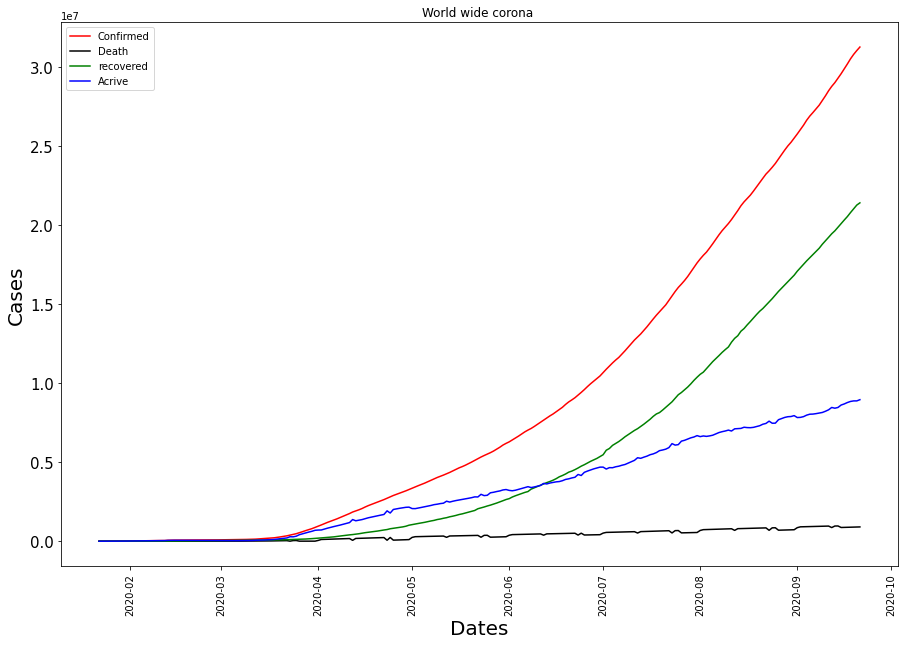

In [42]:
confirmed = df_final.groupby('Date')['Confirmed'].sum().reset_index()
death = df_final.groupby('Date')['Deaths'].sum().reset_index()
recovered = df_final.groupby('Date')['Recovered'].sum().reset_index()
active = df_final.groupby('Date')['Active'].sum().reset_index()
plt.figure(figsize=(15,10))
plt.xticks(rotation = 90, fontsize= 10)
plt.xlabel('Dates').set_size(20)
plt.ylabel('Cases').set_size(20)
plt.title('World wide corona ')
plt.yticks(fontsize =15)
plt.plot(confirmed.Date,confirmed.Confirmed,'red',label='Confirmed')
plt.plot(death.Date,death.Deaths,'black',label='Death')
plt.plot(recovered.Date,recovered.Recovered,'green',label='recovered')
plt.plot(active.Date,active.Active,'blue',label='Acrive')
plt.legend()


#### Observation

1. RED - Confirmed cases

-> From the graph it is clear that number of covid patients are increasing day by day and month on month. This situation is very dangerous

-> We can see an raise in the number of confirmed cases by the mid of march. And also a rapid increase in the number of confirmed cases from the month of july. 

2. GREEN - Recovered cases

-> From the plot it is clear that Recovered is directly propotional to the confirmed cases. That is, the number of recovered cases increases along with the increases in the number of confirmed  cases. That is a good sign because majority of the people are being recovered after affected by the corona virus.

3. Blue - Active cases

-> On closer observation we can see fluctuation in the active cases line. This is beacuse it is affected by the Confimed cases and the recovered cases. It is clear that the number of Active cases are less. This is because Majority of the confirmed cases have been recovered.

4. Black - Death

-> This line indicates the mortality rate. As the plot indicates the mortality rate of corona virus is very low.



### Top 20 countries with highest confirmed cases

In [43]:
high_con_case = df_final.groupby('Country')['Confirmed'].sum().reset_index()
high_con_case.sort_values(by='Confirmed',ascending = True,inplace=True)
high_con_case = high_con_case.tail(20)

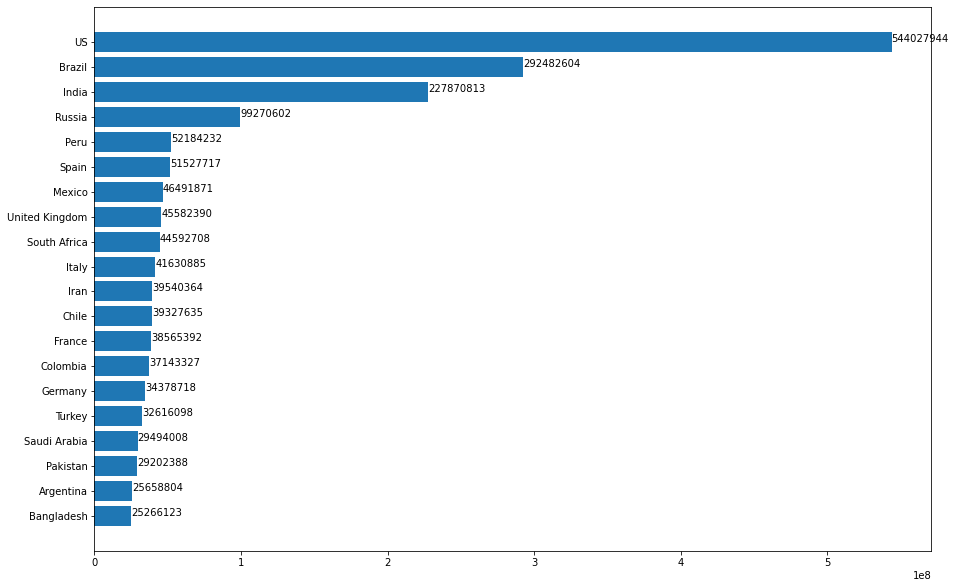

In [44]:
plt.figure(figsize=(15,10))

plt.barh(y=high_con_case.Country,width=high_con_case.Confirmed)
for index, value in enumerate(high_con_case.Confirmed):
    plt.text(value, index,
             str(value))
plt.show()

#### Observation 

-> US is having the largest number of confirmed cases. Almost the sum of confirmed cases in India and Brazil

### Top 20 countries with High Recovery rate

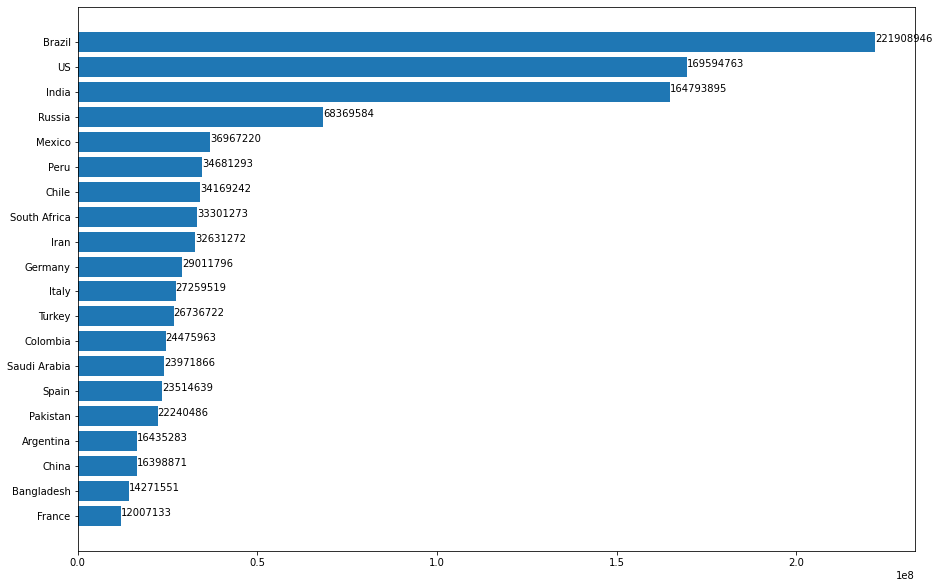

In [45]:
high_rec = df_final.groupby('Country')['Recovered'].sum().reset_index()
high_rec.sort_values(by='Recovered',ascending = True,inplace=True)
high_rec = high_rec.tail(20)

plt.figure(figsize=(15,10))
plt.barh(y=high_rec.Country,width=high_rec.Recovered)
for index, value in enumerate(high_rec.Recovered):
    plt.text(value, index,
             str(value))
plt.show()

#### Observation

-> Brazil is having higher number of recovered cases. Almost 70% of the people are recovered.

-> US is second in cases of recovery. But its only around 20% that of the confirmed.

-> India being 3rd place, almost 65- 70% of confirmed cases are covovered.



### Top 20 countries with highest death rate

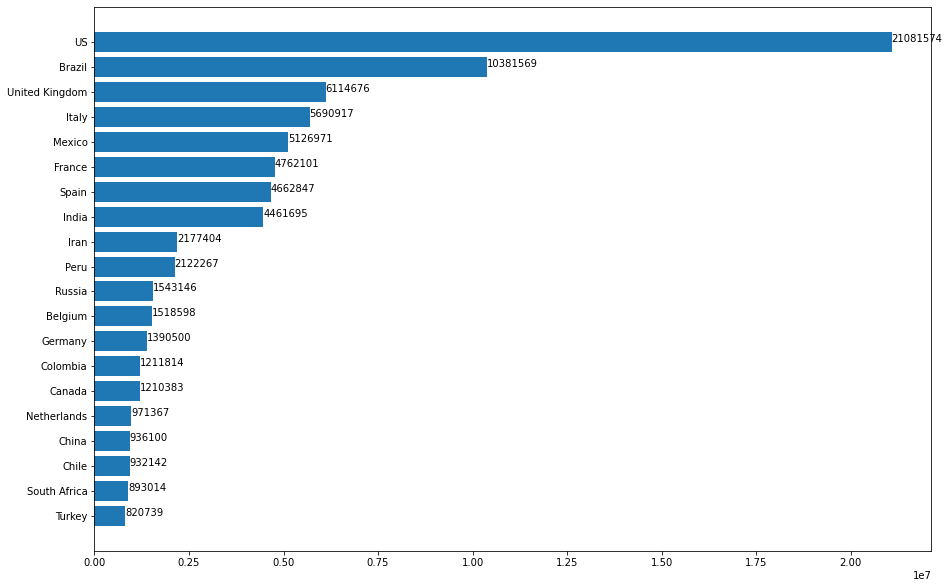

In [46]:
high_death_rate = df_final.groupby('Country')['Deaths'].sum().reset_index()
high_death_rate.sort_values(by='Deaths',ascending = True,inplace=True)
high_death_rate = high_death_rate.tail(20)

plt.figure(figsize=(15,10))
plt.barh(y=high_death_rate.Country,width=high_death_rate.Deaths)
for index, value in enumerate(high_death_rate.Deaths):
    plt.text(value, index,
             str(value))
plt.show()

##### Observations
--> US stand 1st in mortality rate. 
--> this is a good sign that India has very less mortality rate compared to other populated countries

### Top 20 countries with highest Active cases

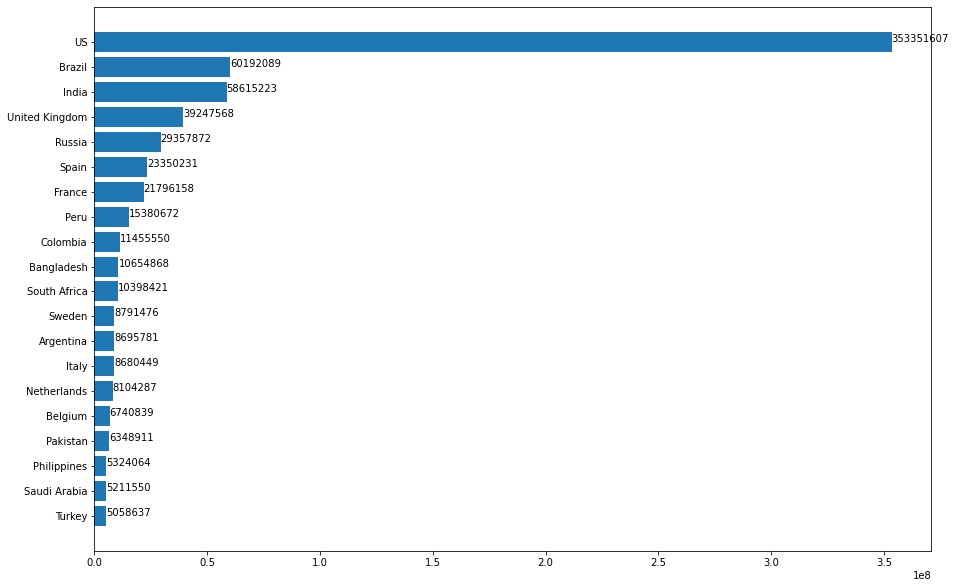

In [47]:
high_active = df_final.groupby('Country')['Active'].sum().reset_index()
high_active.sort_values(by='Active',ascending = True,inplace=True)
high_active = high_active.tail(20)

plt.figure(figsize=(15,10))
plt.barh(y=high_active.Country,width=high_active.Active)
for index, value in enumerate(high_active.Active):
    plt.text(value, index,
             str(value))
plt.show()

### Selecting top 5 countries with highest number of Active cases

In [48]:
countries = ['US','Brazil','Spain','India','Russia']
top_5 = df_final[df_final.Country.isin(countries)]

In [49]:
fig = px.line(top_5, x="Date", y='Confirmed', color='Country', 
                   title='Confirmed', 
                  color_discrete_sequence = px.colors.qualitative.G10)
fig.update_layout(showlegend=True)
fig.show()

In [50]:
fig = px.line(top_5, x="Date", y='Recovered', color='Country', 
                   title='Recovered', 
                  color_discrete_sequence = px.colors.qualitative.G10)
fig.update_layout(showlegend=True)
fig.show()

In [51]:
fig = px.line(top_5, x="Date", y='Deaths', color='Country', 
                   title='Deaths', 
                  color_discrete_sequence = px.colors.qualitative.G10)
fig.update_layout(showlegend=True)
fig.show()

In [52]:
fig = px.line(top_5, x="Date", y='Active', color='Country', 
                   title='Active', 
                  color_discrete_sequence = px.colors.qualitative.G10)
fig.update_layout(showlegend=True)
fig.show()

# 5.Time series forcasting for 5 Countries using prophet

### Prophet
We use Prophet, a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well. It is also an open source software released by Facebook’s Core Data Science team. It is available for download on CRAN and PyPI.

### Why Prophet?
Prophet is easy to customize and use, and to produce accurate forecasts which can be explained intuitively with supporting evidence such as forecast seasonality components. It allows the analyst to explain in an intuitive and convinving manner to higher management as to why the forecasts are as such, and the plausible underlying factors that contribute to its result. Furthermore, it is also open-source! 

### 1.Recovered

In [54]:
recovered = top_5.groupby('Date').sum()['Recovered'].reset_index()

In [112]:
start_date = '2020-05-01'
data = recovered.Date >= start_date
recovered = recovered.loc[data]

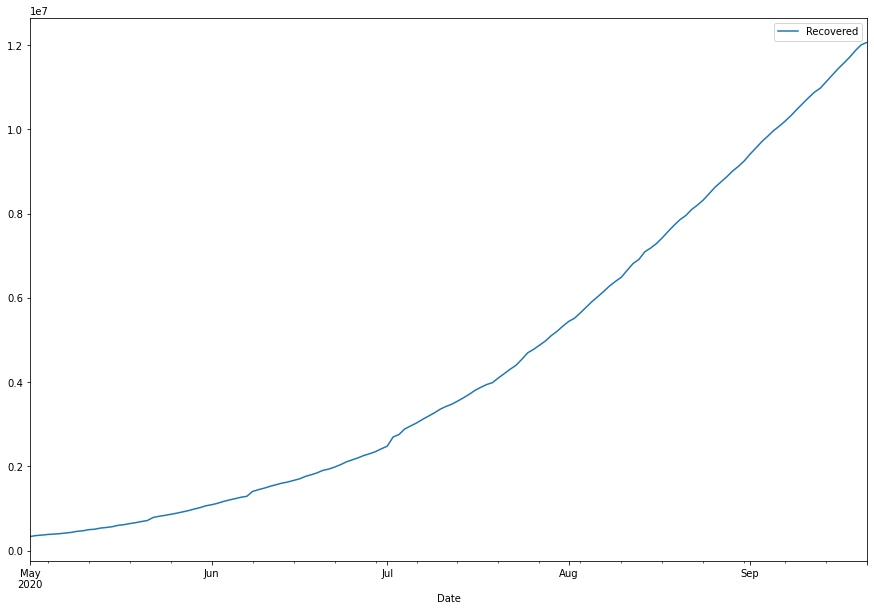

In [113]:

recovered.set_index('Date',inplace=True)
recovered.plot(figsize=(15,10))

### Checking for non statinoray data

In [114]:
test_result = adfuller(recovered.Recovered)

In [115]:
def adfuller_test(recovered):
    result=adfuller(recovered)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [116]:
adfuller_test(recovered.Recovered)

ADF Test Statistic : 0.3640895259691569
p-value : 0.9801011931380772
#Lags Used : 8
Number of Observations Used : 135
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [117]:
recovered['First_diff'] = recovered.Recovered - recovered.Recovered.shift(1)
#seasonal differencing
recovered['second_diff'] = recovered.Recovered - recovered.Recovered.shift(6)

In [118]:
recovered

Recovered  First_diff  second_diff
Date                                          
2020-05-01     337331         NaN          NaN
2020-05-02     359399     22068.0          NaN
2020-05-03     370459     11060.0          NaN
2020-05-04     385280     14821.0          NaN
2020-05-05     395505     10225.0          NaN
...               ...         ...          ...
2020-09-17   11570340    136391.0     817086.0
2020-09-18   11711231    140891.0     829396.0
2020-09-19   11871303    160072.0     892524.0
2020-09-20   12007323    136020.0     876688.0
2020-09-21   12065182     57859.0     784121.0

[144 rows x 3 columns]

In [119]:
# taking seasonal differencing
recovered.drop(columns=['Recovered','First_diff'],inplace=True)
recovered.reset_index(inplace=True)


In [120]:
recovered.columns = ['ds','y']
recovered['ds'] = pd.to_datetime(recovered['ds'])
m = Prophet(interval_width=0.95,weekly_seasonality=True)
m.fit(recovered)
future = m.make_future_dataframe(periods = 7)
future.tail()
forecast = m.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail(7)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ds           yhat     yhat_lower    yhat_upper
144 2020-09-22  857938.467880  754668.344991  9.567188e+05
145 2020-09-23  865065.876514  761998.187893  9.682695e+05
146 2020-09-24  870735.822842  757968.272681  9.727069e+05
147 2020-09-25  873417.107536  776753.053554  9.841364e+05
148 2020-09-26  899109.536769  793975.844076  1.002152e+06
149 2020-09-27  882175.181848  772254.217427  9.899202e+05
150 2020-09-28  876936.621434  767027.478290  9.777222e+05

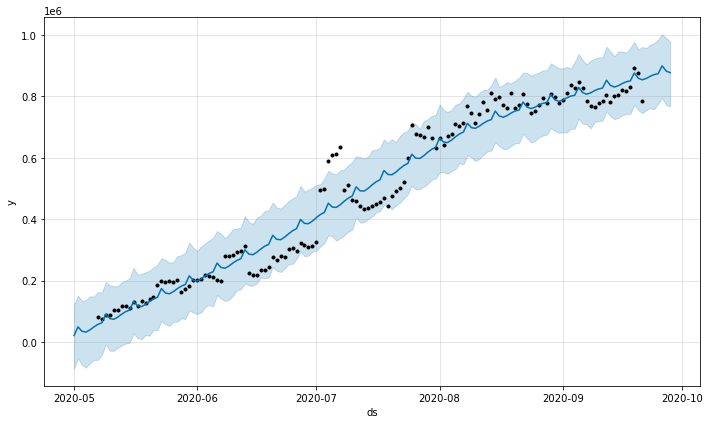

In [121]:
recovered_forecast = m.plot(forecast)

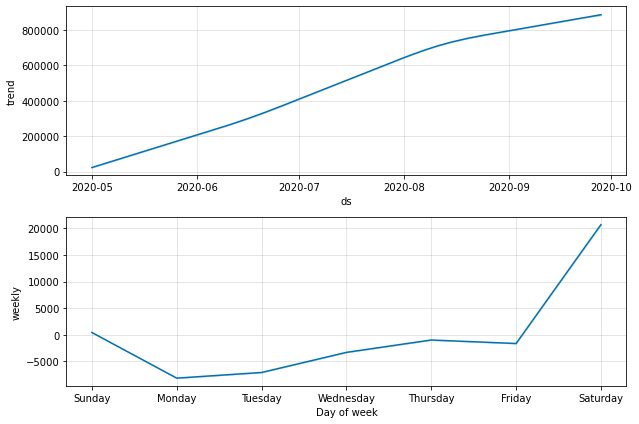

In [122]:
recovered_forecast_plot = m.plot_components(forecast)

In [123]:
metric_df = forecast.set_index('ds')[['yhat']].join(recovered.set_index('ds').y).reset_index()
metric_df.dropna(inplace=True)
r2_score(metric_df.y, metric_df.yhat)

0.9582072840145334

In [124]:
metric_df.tail()

ds           yhat         y
139 2020-09-17  847332.244499  817086.0
140 2020-09-18  850013.529192  829396.0
141 2020-09-19  875705.958425  892524.0
142 2020-09-20  858771.603504  876688.0
143 2020-09-21  853533.043091  784121.0

In [125]:
mean_absolute_percentage_error(metric_df.y, metric_df.yhat)

0.10916730576524945

In [126]:
mean_absolute_error(metric_df.y, metric_df.yhat)

41440.50319585555

#### Observation 

-> Next 7 day forcasting of Recovered cases

2020-09-22 -	857938.467880

2020-09-23 -	865065.876514	

2020-09-24 -    870735.822842	

2020-09-25 -	873417.107536	

2020-09-26 -	899109.536769		

2020-09-27 -	882175.181848

2020-09-28 -	876936.621434	

-> There is an increase in the number of recovered cases till 2020-09-26. But after that the number of recovered cases decreases.

-> While going through Weekly data there is a steady increase in the number of recovered cases. 

-> The model is having an r2 score of 95% and mean absolute percentage error of 10.9%. 

### 2.Death

In [71]:
deaths = top_5.groupby('Date').sum()['Deaths'].reset_index()

In [72]:
start_date = '2020-04-01'
data = deaths.Date >= start_date
deaths = deaths.loc[data]

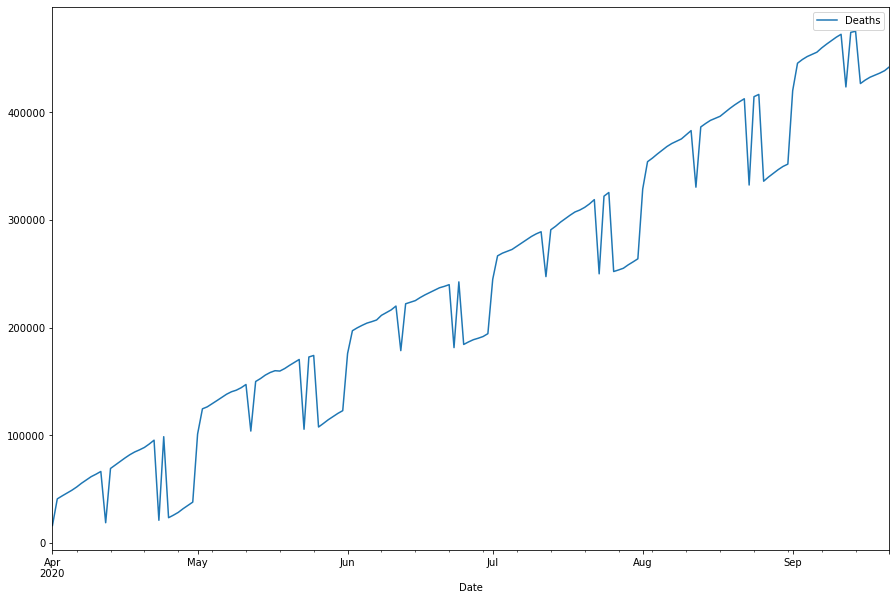

In [73]:
deaths.set_index('Date',inplace=True)
deaths.plot(figsize=(15,10))

In [74]:
deaths.reset_index(inplace=True)

In [75]:
deaths.columns = ['ds','y']
deaths['ds'] = pd.to_datetime(deaths['ds'])
m = Prophet(interval_width=0.95)
m.fit(deaths)
future = m.make_future_dataframe(periods = 7)
future.tail()
forecast = m.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail(7)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ds           yhat     yhat_lower     yhat_upper
174 2020-09-22  462633.234400  400575.236581  522324.922776
175 2020-09-23  466714.454199  402273.320299  530667.020600
176 2020-09-24  465105.636591  402939.343668  526387.903282
177 2020-09-25  474313.460687  410312.087610  539429.287837
178 2020-09-26  473848.851956  411664.023726  537792.630816
179 2020-09-27  471295.036041  409241.972430  530250.547861
180 2020-09-28  482558.485949  421773.872941  547014.491414

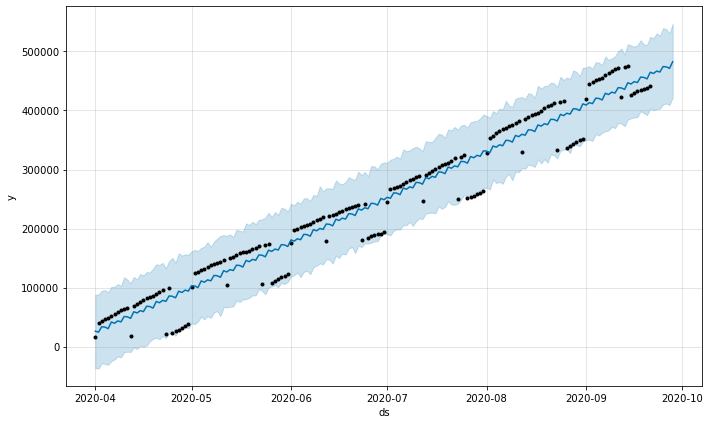

In [76]:
death_forecast = m.plot(forecast)

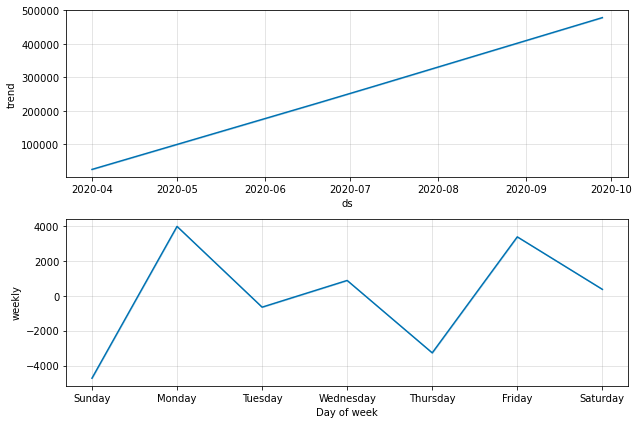

In [77]:
death_forecast_plot = m.plot_components(forecast)

In [78]:
metric_df = forecast.set_index('ds')[['yhat']].join(deaths.set_index('ds').y).reset_index()
metric_df.dropna(inplace=True)

In [79]:
metric_df.tail()

ds           yhat         y
169 2020-09-17  447268.369627  432492.0
170 2020-09-18  456476.193723  434419.0
171 2020-09-19  456011.584992  436277.0
172 2020-09-20  453457.769077  438540.0
173 2020-09-21  464721.218985  442168.0

In [80]:
r2_score(metric_df.y, metric_df.yhat)

0.9423375627106628

In [81]:
mean_absolute_percentage_error(metric_df.y, metric_df.yhat)

0.22203301641473286

In [82]:
mean_absolute_error(metric_df.y, metric_df.yhat)

26340.626025067097

#### Observation

-> Next 7 day forcasting of Death Cases

2020-09-22 - 462633.234400

2020-09-23 - 466714.454199

2020-09-24 - 465105.636591

2020-09-25 - 474313.460687

2020-09-26 - 473848.851956

2020-09-27 - 471295.036041

2020-09-28 - 482558.485949

-> There is an increase in the number of death cases.

-> While going through the weekly data it is observed that monday and friday is having higher number of death cases.

-> The model is having an r2 score of 0.94 and mean absolute percentage error of 0.22


### 3.Confirmed

In [154]:
confirmed = top_5.groupby('Date').sum()['Confirmed'].reset_index()

In [155]:
start_date = '2020-04-01'
data = confirmed.Date >= start_date
confirmed = confirmed.loc[data]

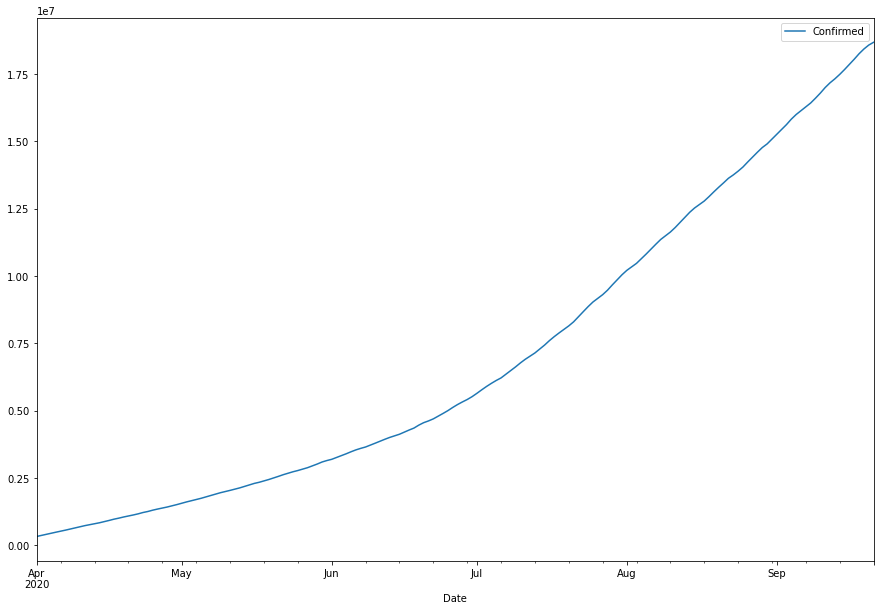

In [156]:
confirmed.set_index('Date',inplace=True)
confirmed.plot(figsize=(15,10))

### Checking for non statinoray data

In [157]:
test_result = adfuller(confirmed.Confirmed)

In [158]:
def adfuller_test(confirmed):
    result=adfuller(confirmed)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [159]:
adfuller_test(confirmed.Confirmed)

ADF Test Statistic : -2.5437422570894457
p-value : 0.10519076787100845
#Lags Used : 14
Number of Observations Used : 159
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [160]:
confirmed['First_diff'] = confirmed.Confirmed - confirmed.Confirmed.shift(1)
#seasonal differencing
confirmed['second_diff'] = confirmed.Confirmed - confirmed.Confirmed.shift(5)

In [161]:
# taking differencing
confirmed.drop(columns=['Confirmed','second_diff'],inplace=True)
confirmed.reset_index(inplace=True)


In [162]:
confirmed

Date  First_diff
0   2020-04-01         NaN
1   2020-04-02     40876.0
2   2020-04-03     40708.0
3   2020-04-04     42522.0
4   2020-04-05     35286.0
..         ...         ...
169 2020-09-17    194045.0
170 2020-09-18    202848.0
171 2020-09-19    175808.0
172 2020-09-20    146088.0
173 2020-09-21    102999.0

[174 rows x 2 columns]

In [163]:
confirmed.columns = ['ds','y']
confirmed['ds'] = pd.to_datetime(confirmed['ds'])
m = Prophet(interval_width=0.95)
m.fit(confirmed)
future = m.make_future_dataframe(periods = 7)
future.tail()
forecast = m.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail(7)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ds           yhat     yhat_lower     yhat_upper
174 2020-09-22  175276.064543  151260.146322  197541.111955
175 2020-09-23  185067.137572  162617.294067  207873.221297
176 2020-09-24  186899.904292  163750.248794  208902.759690
177 2020-09-25  189573.087611  166919.256675  212080.438908
178 2020-09-26  178998.421086  156716.028891  199822.211814
179 2020-09-27  160319.084051  137505.433425  183640.132363
180 2020-09-28  159866.846740  136880.617487  183129.198080

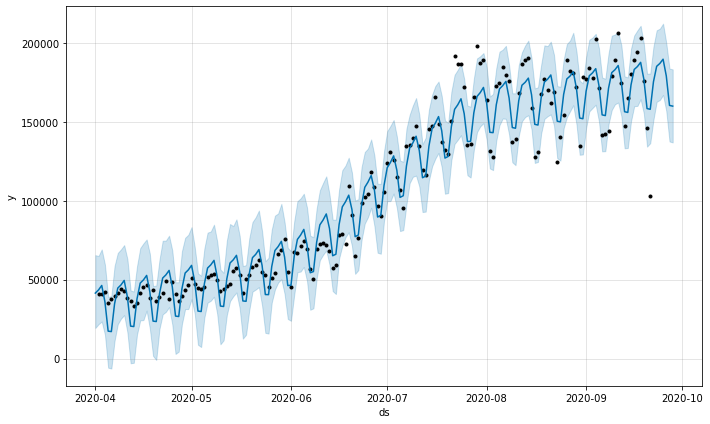

In [164]:
confirmed_forecast = m.plot(forecast)

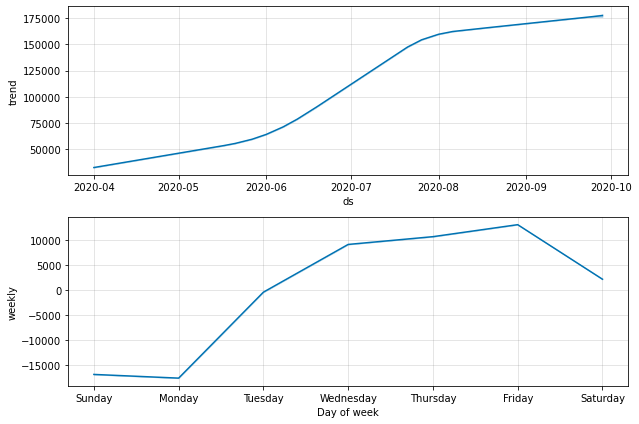

In [165]:
confirmed_forecast_plot = m.plot_components(forecast)

In [166]:
metric_df = forecast.set_index('ds')[['yhat']].join(confirmed.set_index('ds').y).reset_index()
metric_df.dropna(inplace=True)

In [167]:
metric_df.tail()

ds           yhat         y
169 2020-09-17  184904.384982  194045.0
170 2020-09-18  187577.568301  202848.0
171 2020-09-19  177002.901775  175808.0
172 2020-09-20  158323.564741  146088.0
173 2020-09-21  157871.327430  102999.0

In [168]:
r2_score(metric_df.y, metric_df.yhat)

0.9556923573953179

In [169]:
mean_absolute_percentage_error(metric_df.y, metric_df.yhat)

0.11032055466939511

In [170]:
mean_absolute_error(metric_df.y, metric_df.yhat)

8912.170437889892

#### Observation

-> Next 7 day forcasting of Confirmed cases

2020-09-22	175276.064543		

2020-09-23	185067.137572		

2020-09-24	186899.904292	

2020-09-25	189573.087611		

2020-09-26	178998.421086	

2020-09-27	160319.084051		

2020-09-28	159866.846740		


-> You can see an increase in the number of confirmed cases till 2020-09-25.

-> From 2020-09-26 a decrease in the number of confirmed cases is visible.

-> On weekly plot analysis sunday and monday is having lower number of confirmed cases. This is beacuse sunday is a holiday so maybe there will be less tests happening. 

-> The model is having an r2score of 0.95 and mean absolute perentage error of 0.11

# 6.Time series forcasting using SARIMAX

## WHY SARIMA?
#### SARIMA - Seasonal Autoregressive Integrated Moving Average
#### Autoregressive Integrated Moving Average, or ARIMA, is one of the most widely used forecasting methods for univariate time series data forecasting.

#### Although the method can handle data with a trend, it does not support time series with a seasonal component.
### The dataset considered for prediction and forecasting is very much seasonal .

#### An extension to ARIMA that supports the direct modeling of the seasonal component of the series is called SARIMA.

##### In below analysis we have considered only Recovered and Deaths dataset ,as these 2 are seasonal in nature compared to Confirmed dataset with is more likely Trending dataset

### 1.Recovered

In [53]:
top_5

state Country        Lat        Long       Date  Confirmed  Deaths  \
Id                                                                         
30      NaN  Brazil -14.235000  -51.925300 2020-01-22          0       0   
129     NaN   India  20.593684   78.962880 2020-01-22          0       0   
193     NaN  Russia  61.524010  105.318756 2020-01-22          0       0   
211     NaN   Spain  40.463667   -3.749220 2020-01-22          0       0   
227     NaN      US  40.000000 -100.000000 2020-01-22          1       0   
...     ...     ...        ...         ...        ...        ...     ...   
61023   NaN  Brazil -14.235000  -51.925300 2020-09-21    4558040  128539   
61122   NaN   India  20.593684   78.962880 2020-09-21    5487580   75062   
61186   NaN  Russia  61.524010  105.318756 2020-09-21    1105048   18080   
61204   NaN   Spain  40.463667   -3.749220 2020-09-21     671468   29628   
61220   NaN      US  40.000000 -100.000000 2020-09-21    6856884  190859   

       Recovered   Active  
Id                         
30             0        0  
129            0        0  
193            0        0  
211            0        0  
227            0        1  
...          ...      ...  
61023    3993432   436069  
61122    4396399  1016119  
61186     909026   177942  
61204     150376   491464  
61220    2615949  4050076  

[1220 rows x 9 columns]

In [54]:
#considering the data from JUne month , as we have actual numbers and we see sharp raise in all parameter from June
start_date = '2020-06-01'
data = top_5['Date'] >= start_date
top_5 = top_5.loc[data]
top_5

state Country        Lat        Long       Date  Confirmed  Deaths  \
Id                                                                         
32911   NaN  Brazil -14.235000  -51.925300 2020-06-01     526447   29937   
33010   NaN   India  20.593684   78.962880 2020-06-01     198370    5608   
33074   NaN  Russia  61.524010  105.318756 2020-06-01     414328    4849   
33092   NaN   Spain  40.463667   -3.749220 2020-06-01     239638   27127   
33108   NaN      US  40.000000 -100.000000 2020-06-01    1816479  108283   
...     ...     ...        ...         ...        ...        ...     ...   
61023   NaN  Brazil -14.235000  -51.925300 2020-09-21    4558040  128539   
61122   NaN   India  20.593684   78.962880 2020-09-21    5487580   75062   
61186   NaN  Russia  61.524010  105.318756 2020-09-21    1105048   18080   
61204   NaN   Spain  40.463667   -3.749220 2020-09-21     671468   29628   
61220   NaN      US  40.000000 -100.000000 2020-09-21    6856884  190859   

       Recovered   Active  
Id                         
32911     211080   285430  
33010      95754    97008  
33074     175514   233965  
33092     150376    62135  
33108     458231  1249965  
...          ...      ...  
61023    3993432   436069  
61122    4396399  1016119  
61186     909026   177942  
61204     150376   491464  
61220    2615949  4050076  

[565 rows x 9 columns]

<AxesSubplot:xlabel='Id'>

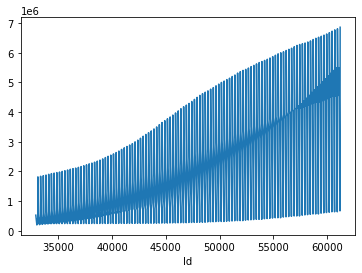

In [55]:
top_5['Confirmed'].plot()

##### Confirmed data set seems to be TREND in nature

<AxesSubplot:xlabel='Id'>

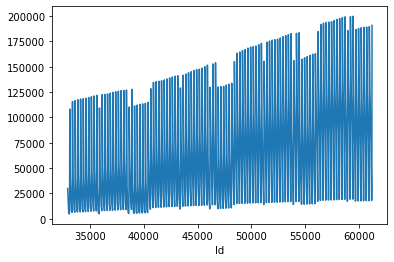

In [56]:
top_5['Deaths'].plot()

##### Deaths Dataset seems to be seasonal in nature

<AxesSubplot:xlabel='Id'>

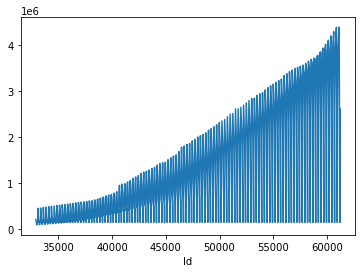

In [57]:
top_5['Recovered'].plot()

##### Recovered data set is also more likely to be seasonal in nature

### Analysis for Recovered data for top 5 countries

In [61]:
recovered = top_5.groupby('Date').sum()['Recovered'].reset_index()

<AxesSubplot:xlabel='Date'>

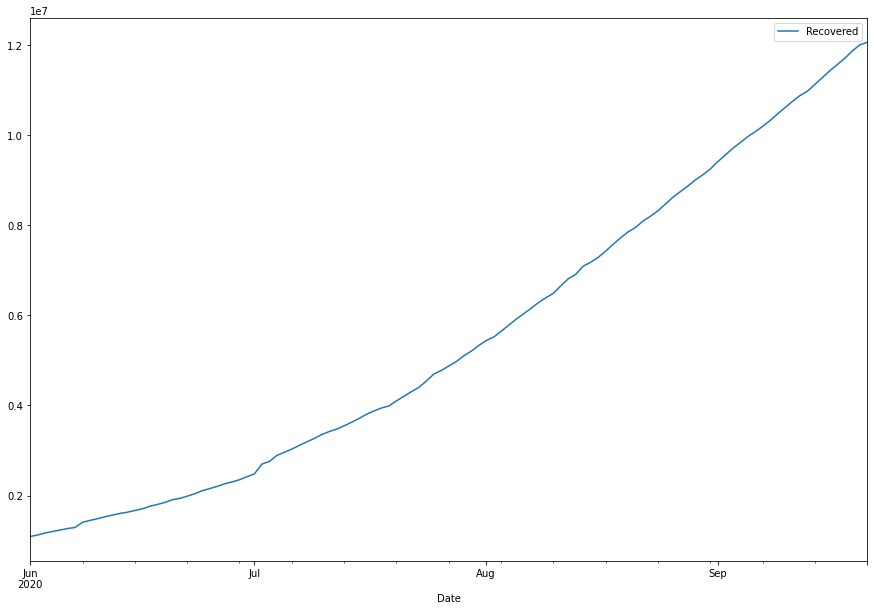

In [62]:
recovered.set_index('Date',inplace=True)
recovered.plot(figsize=(15,10))

In [63]:
recovered

Recovered
Date                 
2020-06-01    1090955
2020-06-02    1124769
2020-06-03    1167881
2020-06-04    1202988
2020-06-05    1234492
...               ...
2020-09-17   11570340
2020-09-18   11711231
2020-09-19   11871303
2020-09-20   12007323
2020-09-21   12065182

[113 rows x 1 columns]

#### To proceed with out analysis, we need make sure our data set is completely stationary . Looking at the plots we made initially, it is evident that the data is not stationary with such a clear trend and seasonality. However, we can be more scientific with our guess by employing a statistical test: the Augmented Dickey-Fuller test, also implemented in the statsmodels package

In [64]:
#define function for ADF test
def adfuller_test(recovered):
    result=adfuller(recovered)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [65]:
#apply adf test on the series for recovered
adfuller_test(recovered.Recovered)

ADF Test Statistic : 3.4254361713195842
p-value : 1.0
#Lags Used : 2
Number of Observations Used : 110
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


##### Just as expected, the p-value is bigger than 0.05. Thus, we cannot reject the null hypothesis, and the time series is not stationary

#### To make the data stationary a procedure called Differencing.Differencing the data simply means to take the difference between the data points and its lagged version

<AxesSubplot:xlabel='Date'>

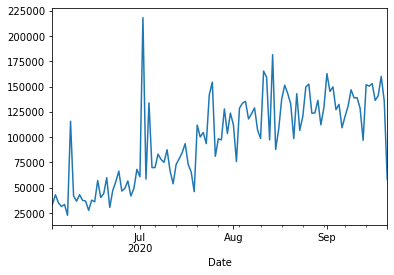

In [66]:
#First Diff
recovered['Recovered_diff1']= recovered['Recovered'] - recovered['Recovered'].shift(1)
recovered['Recovered_diff1'].dropna().plot()

<AxesSubplot:xlabel='Date'>

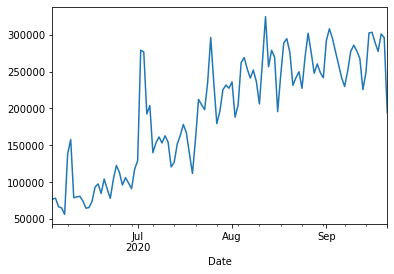

In [67]:
#Seasonal differencing
n=2
recovered['Recovered_diff2']= recovered['Recovered'] - recovered['Recovered'].shift(n)
recovered['Recovered_diff2'].dropna().plot()

<AxesSubplot:xlabel='Date'>

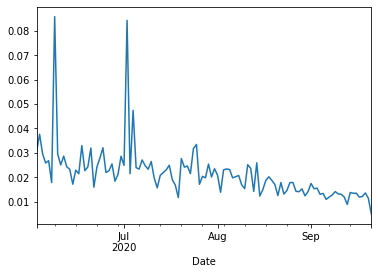

In [68]:
# Transformation
recovered['Recovered_log'] = np.log(recovered['Recovered'])
recovered['Recovered_log_diff'] = recovered['Recovered_log'] - recovered['Recovered_log'].shift(1)
recovered['Recovered_log_diff'].dropna().plot()

In [71]:
# drop Nan vaules
recovered = recovered.replace([np.inf],np.nan)
recovered.dropna(inplace=True)

In [72]:
recovered

Recovered  Recovered_diff1  Recovered_diff2  Recovered_log  \
Date                                                                     
2020-06-03    1167881          43112.0          76926.0      13.970702   
2020-06-04    1202988          35107.0          78219.0      14.000319   
2020-06-05    1234492          31504.0          66611.0      14.026170   
2020-06-06    1268004          33512.0          65016.0      14.052955   
2020-06-07    1290815          22811.0          56323.0      14.070784   
...               ...              ...              ...            ...   
2020-09-17   11570340         136391.0         289279.0      16.263955   
2020-09-18   11711231         140891.0         277282.0      16.276059   
2020-09-19   11871303         160072.0         300963.0      16.289635   
2020-09-20   12007323         136020.0         296092.0      16.301027   
2020-09-21   12065182          57859.0         193879.0      16.305834   

            Recovered_log_diff  
Date                            
2020-06-03            0.037613  
2020-06-04            0.029617  
2020-06-05            0.025851  
2020-06-06            0.026784  
2020-06-07            0.017830  
...                        ...  
2020-09-17            0.011858  
2020-09-18            0.012103  
2020-09-19            0.013576  
2020-09-20            0.011393  
2020-09-21            0.004807  

[111 rows x 5 columns]

<function matplotlib.pyplot.show(close=None, block=None)>

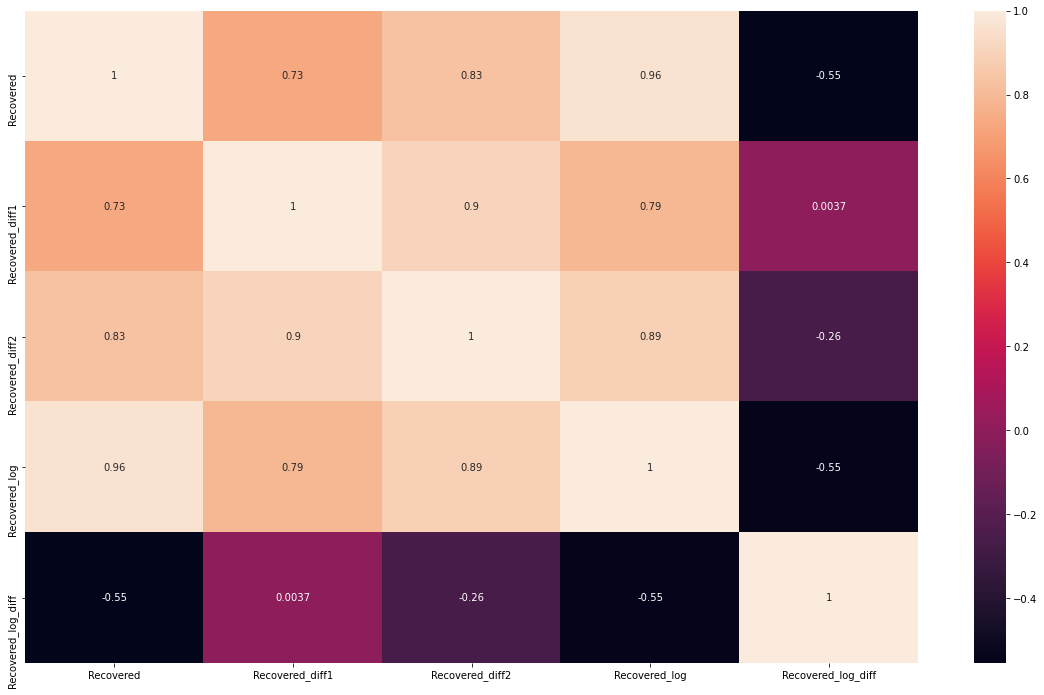

In [73]:
# check the correlation between all the columns
plt.rcParams['figure.figsize'] = 20,12
corr_ind = recovered.corr()
sns.heatmap(corr_ind,annot=True)
plt.show

#### looking into heat map Recovered_log is highly correlated with Recovered data

In [74]:
#apply adf test on the series for recovered after defferencing
adfuller_test(recovered.Recovered_log)

ADF Test Statistic : -4.699882131368982
p-value : 8.419569241521877e-05
#Lags Used : 2
Number of Observations Used : 108
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


##### applying test again , we see that the data is made stationary . This  is evident by seeing P-value

In [75]:
#Split the data
X=recovered.index
y=recovered.Recovered_log
#X=recovered.values

predictions=[]

In [76]:
#split for traing and test data
train_size=int(len(recovered) *0.7)
test_size = int(len(recovered)) - train_size

train_X, train_y = X[:train_size], y[:train_size]
test_X, test_y = X[train_size:].dropna(), y[train_size:].dropna()

In [77]:
train_size

77

## Parameter Selection for the SARIMAX Time Series Model
#### When looking to fit time series data with a seasonal ARIMA model, our first goal is to find the values of ARIMA(P,D,Q)S that optimize a metric of interest

In [78]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

In [79]:
import itertools
import statsmodels.api as sm

In [80]:
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [81]:
# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 10) for x in list(itertools.product(p, d, q))]
seasonal_pdq

[(0, 0, 0, 10),
 (0, 0, 1, 10),
 (0, 1, 0, 10),
 (0, 1, 1, 10),
 (1, 0, 0, 10),
 (1, 0, 1, 10),
 (1, 1, 0, 10),
 (1, 1, 1, 10)]

In [82]:
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 10)
SARIMAX: (0, 0, 1) x (0, 1, 0, 10)
SARIMAX: (0, 1, 0) x (0, 1, 1, 10)
SARIMAX: (0, 1, 0) x (1, 0, 0, 10)


#### We will use the AIC (Akaike Information Criterion) value, which is conveniently returned with ARIMA models fitted using statsmodels. The AIC measures how well a model fits the data while taking into account the overall complexity of the model.

In [83]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
#for Confirmed 
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_y, 
                                            #exog= train_X,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 10)12 - AIC:629.369049911112
ARIMA(0, 0, 0)x(0, 0, 1, 10)12 - AIC:548.3926338870654
ARIMA(0, 0, 0)x(0, 1, 0, 10)12 - AIC:4.745832256372389
ARIMA(0, 0, 0)x(0, 1, 1, 10)12 - AIC:-48.058344118395006
ARIMA(0, 0, 0)x(1, 0, 0, 10)12 - AIC:-214.1151916313454
ARIMA(0, 0, 0)x(1, 0, 1, 10)12 - AIC:-212.56142529146535
ARIMA(0, 0, 0)x(1, 1, 0, 10)12 - AIC:-167.2924237510832
ARIMA(0, 0, 0)x(1, 1, 1, 10)12 - AIC:-202.3022719367211
ARIMA(0, 0, 1)x(0, 0, 0, 10)12 - AIC:623.6244956589879
ARIMA(0, 0, 1)x(0, 0, 1, 10)12 - AIC:531.9769159583283
ARIMA(0, 0, 1)x(0, 1, 0, 10)12 - AIC:-79.23756570193943
ARIMA(0, 0, 1)x(0, 1, 1, 10)12 - AIC:-113.81299955359455
ARIMA(0, 0, 1)x(1, 0, 0, 10)12 - AIC:-209.62069251521166
ARIMA(0, 0, 1)x(1, 0, 1, 10)12 - AIC:-267.9174498496038
ARIMA(0, 0, 1)x(1, 1, 0, 10)12 - AIC:-209.2539043172623
ARIMA(0, 0, 1)x(1, 1, 1, 10)12 - AIC:-238.1186417599419
ARIMA(0, 1, 0)x(0, 0, 0, 10)12 - AIC:-326.58967172086204
ARIMA(0, 1, 0)x(0, 0, 1, 10)12 - AIC:-321.7301066

# Fitting SARIMAX Model

In [84]:
model=sm.tsa.statespace.SARIMAX(recovered['Recovered_log'],order=(1, 1, 0),seasonal_order=(1,0,1,10),enforce_stationarity=False,
                                enforce_invertibility=False)
results=model.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0233      0.168     -0.138      0.890      -0.353       0.307
ar.S.L10       0.9084      0.021     42.663      0.000       0.867       0.950
ma.S.L10      -1.0021     16.992     -0.059      0.953     -34.306      32.302
sigma2      7.739e-05      0.001      0.059      0.953      -0.003       0.003


##### coef column shows the weight (i.e. importance) of each feature and how each one impacts the time series. 
##### P>|z| column informs us of the significance of each feature weight 


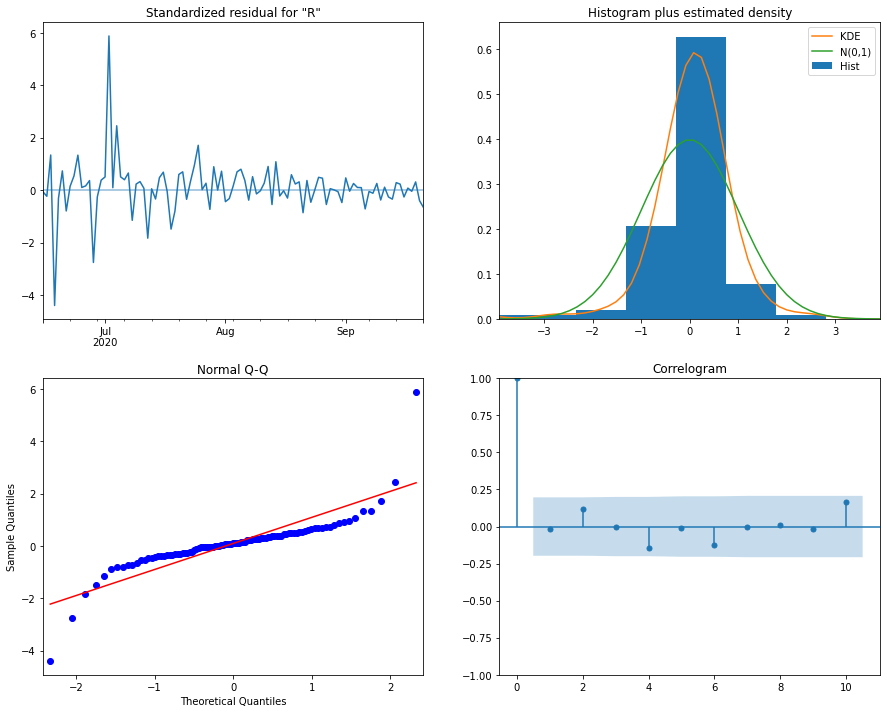

In [85]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

#### To determine the goodness of fit of the model, we can examine its residuals using the standard assumption: they should be normally distributed around 0, or in other words, white noise.

#### Our primary concern is to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean. If the seasonal ARIMA model does not satisfy these properties, it is a good indication that it can be further improved.

#### In this case, our model diagnostics suggests that the model residuals are  not normally distributed based on the following:

#### In the top right plot, we see that the red KDE line do not follow closely with the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). 
### This is a good indication that the residuals are normally distributed.

#### The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) do not follow the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are not very much normally distributed.
#### The residuals over time (top left plot) display any obvious seasonality and appear to be seasonal. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have high correlation with lagged versions of itself.

In [89]:
# forecast using 30 % of the data
recovered['forecast']= results.predict(start=78,end=111,dynamic=True)

In [90]:
recovered

Recovered  Recovered_diff1  Recovered_diff2  Recovered_log  \
Date                                                                     
2020-06-03    1167881          43112.0          76926.0      13.970702   
2020-06-04    1202988          35107.0          78219.0      14.000319   
2020-06-05    1234492          31504.0          66611.0      14.026170   
2020-06-06    1268004          33512.0          65016.0      14.052955   
2020-06-07    1290815          22811.0          56323.0      14.070784   
...               ...              ...              ...            ...   
2020-09-17   11570340         136391.0         289279.0      16.263955   
2020-09-18   11711231         140891.0         277282.0      16.276059   
2020-09-19   11871303         160072.0         300963.0      16.289635   
2020-09-20   12007323         136020.0         296092.0      16.301027   
2020-09-21   12065182          57859.0         193879.0      16.305834   

            Recovered_log_diff   forecast  
Date                                       
2020-06-03            0.037613        NaN  
2020-06-04            0.029617        NaN  
2020-06-05            0.025851        NaN  
2020-06-06            0.026784        NaN  
2020-06-07            0.017830        NaN  
...                        ...        ...  
2020-09-17            0.011858  16.273269  
2020-09-18            0.012103  16.285807  
2020-09-19            0.013576  16.296381  
2020-09-20            0.011393  16.311873  
2020-09-21            0.004807  16.322479  

[111 rows x 6 columns]

<AxesSubplot:xlabel='Date'>

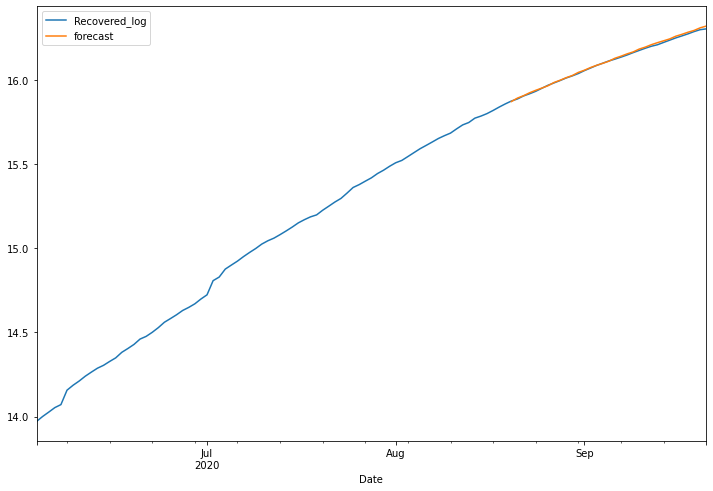

In [88]:
recovered[['Recovered_log','forecast']].plot(figsize=(12,8))

### the above curve shows that forecast is almost same as actual

In [91]:
# remove Nan values to be more clear
recovered1=recovered.dropna()
recovered1.reset_index(inplace=True)

<AxesSubplot:>

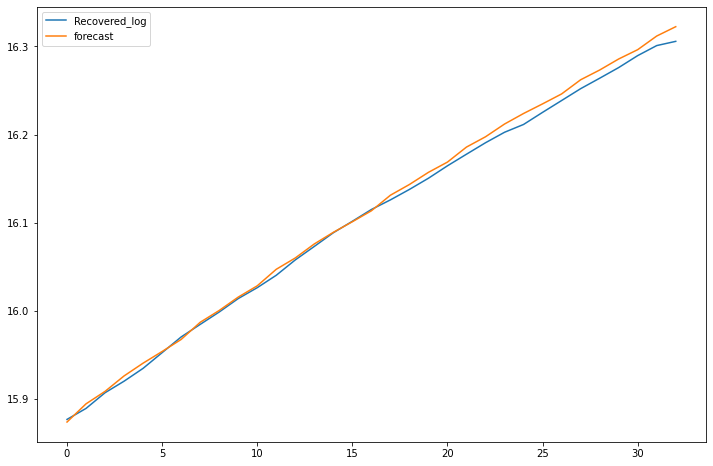

In [92]:
recovered1[['Recovered_log','forecast']].plot(figsize=(12,8))

In [93]:
# Mean Square error
y_forecasted = recovered1['forecast']
y_truth = recovered1['Recovered_log']

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.0


In [94]:
r2_score(recovered1['Recovered_log'], recovered1['forecast'])

0.997205544445528

In [95]:
mean_absolute_percentage_error(recovered1['Recovered_log'], recovered1['forecast'])

0.000350426274250006

In [96]:
mean_absolute_error(recovered1['Recovered_log'], recovered1['forecast'])

0.0056649048056092235

## Future forcast

In [97]:
# forecast for next 7 days
futureForecast= results.predict(start=111,end=117,dynamic=True)

In [98]:
futureForecast.index.name = 'Dates'
futureForecast

Dates
2020-09-22    16.318971
2020-09-23    16.329862
2020-09-24    16.339867
2020-09-25    16.350189
2020-09-26    16.364652
2020-09-27    16.374715
2020-09-28    16.386098
Freq: D, Name: predicted_mean, dtype: float64

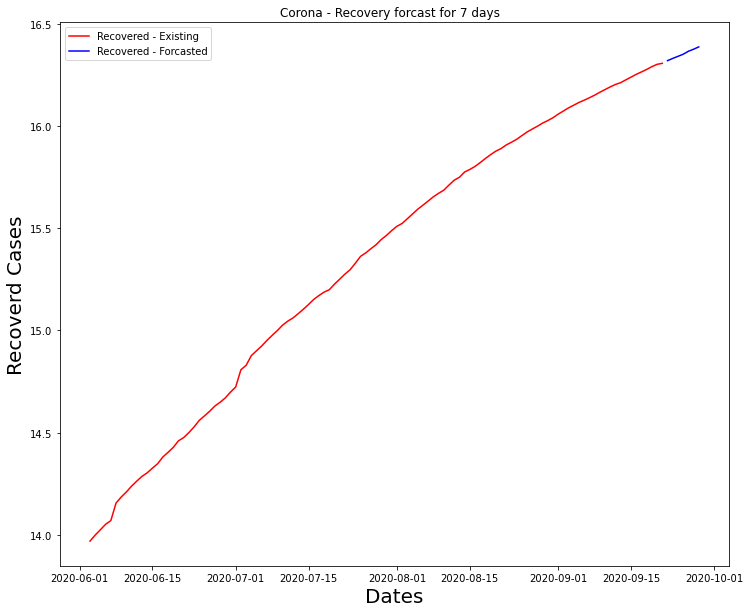

In [99]:
plt.figure(figsize=(12,10))
plt.xticks( fontsize= 10)
plt.xlabel('Dates').set_size(20)
plt.ylabel('Recoverd Cases').set_size(20)
plt.title('Corona - Recovery forcast for 7 days  ')
plt.yticks(fontsize =10)
plt.plot(recovered.Recovered_log,'red',label='Recovered - Existing')
plt.plot(futureForecast,'blue',label='Recovered - Forcasted')
plt.legend()

### by seeing the Future Forecast , we can conclude that number of recoveredcase will be increasing for all the 5 countries. 
### This is a very good sign , inspite of confirmed cases, Recovered case will be increasing .
### If the same trend is followed for next 60 days , we can see that all confiremed case will be recovered and there will be no CORONA cases left.

## Forecasting for Death data

In [100]:
deaths = top_5.groupby('Date').sum()['Deaths'].reset_index()

<AxesSubplot:xlabel='Date'>

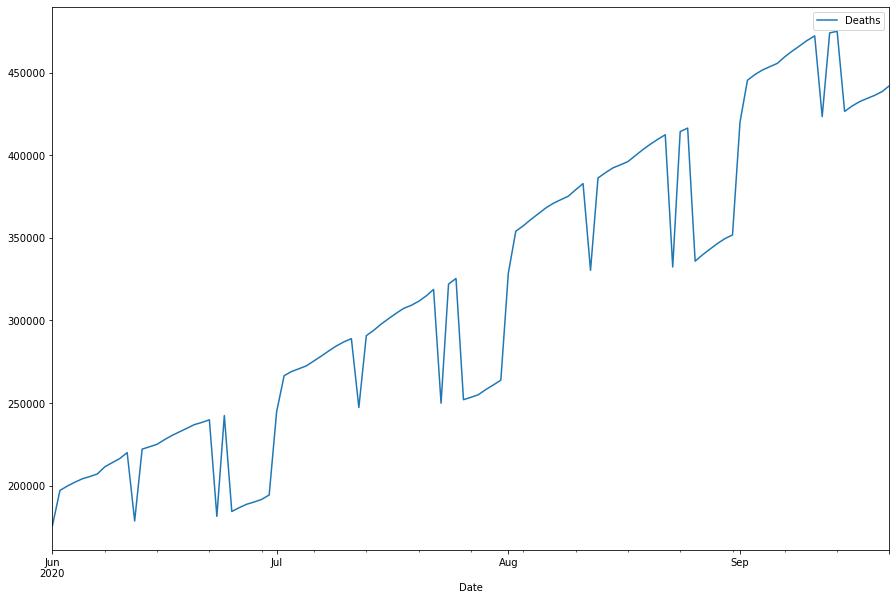

In [101]:
deaths.set_index('Date',inplace=True)
deaths.plot(figsize=(15,10))

#### Looking into the Graphs we can decide that Death data set is seasonal in nature

In [104]:
deaths

Deaths
Date              
2020-06-01  175804
2020-06-02  197030
2020-06-03  199708
2020-06-04  202014
2020-06-05  204090
...            ...
2020-09-17  432492
2020-09-18  434419
2020-09-19  436277
2020-09-20  438540
2020-09-21  442168

[113 rows x 1 columns]

In [102]:
#define function for ADF test
def adfuller_test(deaths):
    result=adfuller(deaths)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [103]:
#apply adf test on the series for recovered
adfuller_test(deaths.Deaths)

ADF Test Statistic : -0.9545201029189806
p-value : 0.769488729027928
#Lags Used : 2
Number of Observations Used : 110
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


#### Since P-Value is more than 0.05 , its has week evidence against null Hypothisis and its non-stationary

#### using Differencing technique data set should be convered to stationary

<AxesSubplot:xlabel='Date'>

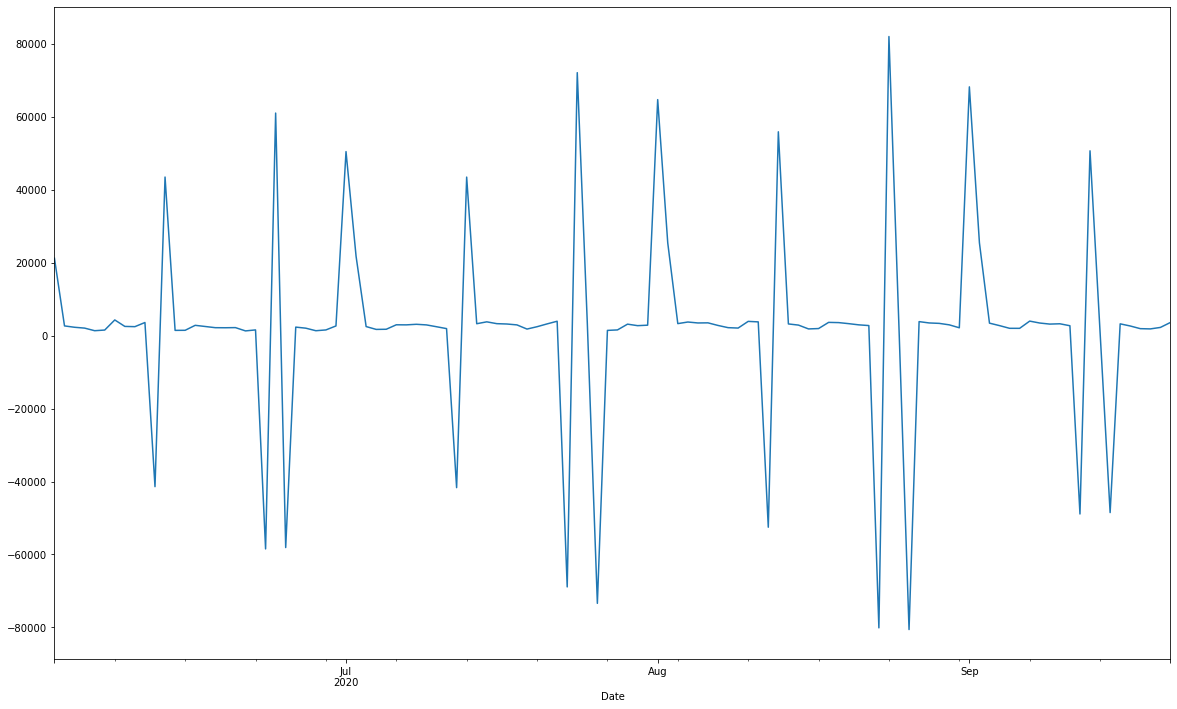

In [104]:
#First Diff
deaths['Deaths_diff1']= deaths['Deaths'] - deaths['Deaths'].shift(1)
deaths['Deaths_diff1'].dropna().plot()

<AxesSubplot:xlabel='Date'>

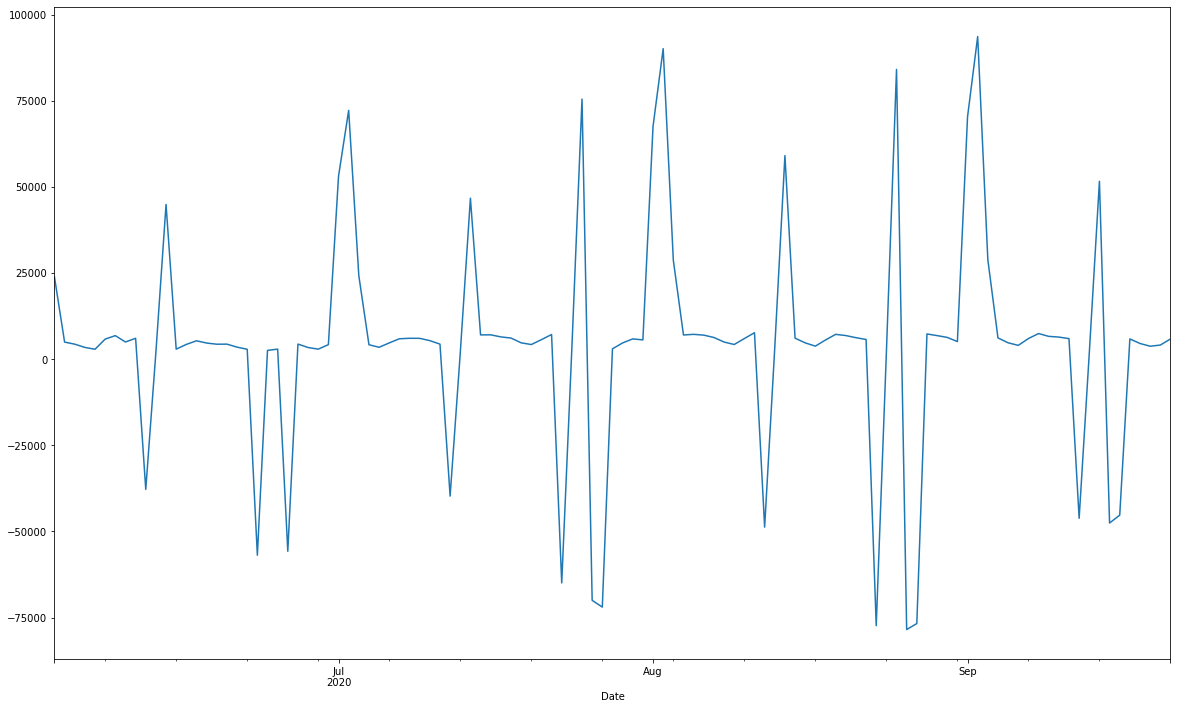

In [105]:
#seasonal/second Diff
n=2
deaths['Deaths_diff2']= deaths['Deaths'] - deaths['Deaths'].shift(n)
deaths['Deaths_diff2'].dropna().plot()

<AxesSubplot:xlabel='Date'>

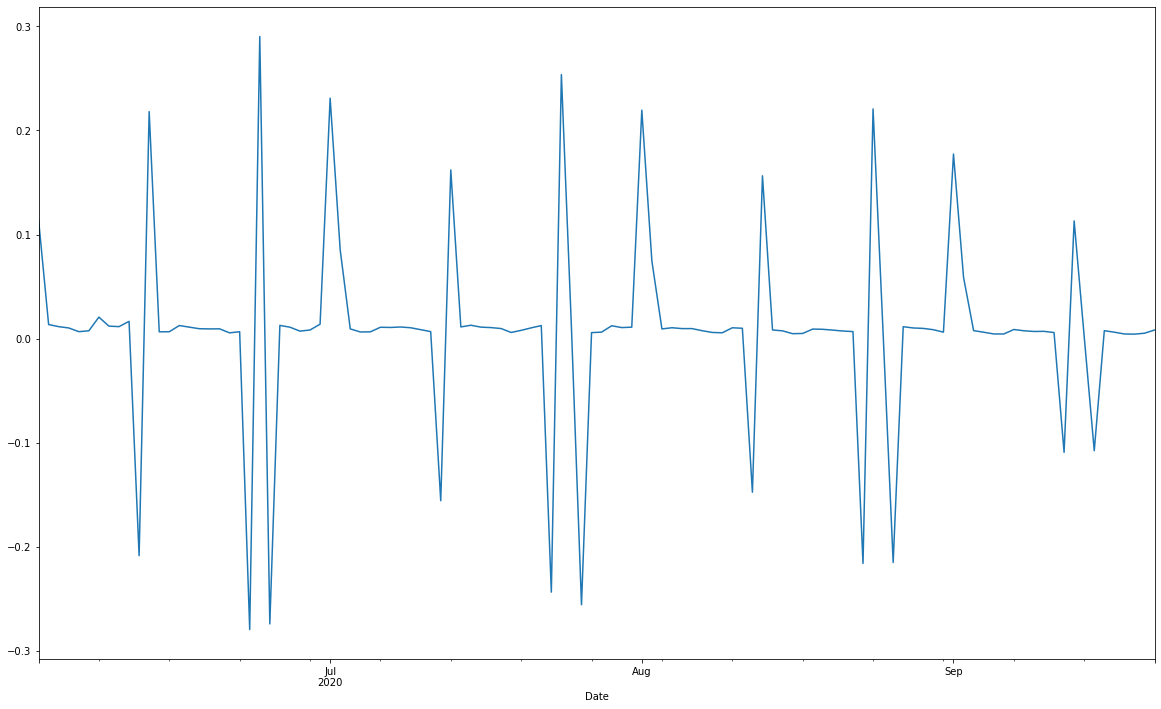

In [106]:
# Transformation
deaths['Deaths_log'] = np.log(deaths['Deaths'])
deaths['Deaths_log_diff'] = deaths['Deaths_log'] - deaths['Deaths_log'].shift(1)
deaths['Deaths_log_diff'].dropna().plot()

In [112]:
deaths

Deaths  Deaths_diff1  Deaths_diff2  Deaths_log  Deaths_log_diff
Date                                                                       
2020-06-01  175804           NaN           NaN   12.077125              NaN
2020-06-02  197030       21226.0           NaN   12.191111         0.113986
2020-06-03  199708        2678.0       23904.0   12.204612         0.013500
2020-06-04  202014        2306.0        4984.0   12.216092         0.011481
2020-06-05  204090        2076.0        4382.0   12.226316         0.010224
...            ...           ...           ...         ...              ...
2020-09-17  432492        2658.0        5903.0   12.977319         0.006165
2020-09-18  434419        1927.0        4585.0   12.981765         0.004446
2020-09-19  436277        1858.0        3785.0   12.986033         0.004268
2020-09-20  438540        2263.0        4121.0   12.991206         0.005174
2020-09-21  442168        3628.0        5891.0   12.999445         0.008239

[113 rows x 5 columns]

In [107]:
# drop Nan vaules
deaths = deaths.replace([np.inf],np.nan)
deaths.dropna(inplace=True)

In [108]:
deaths

Deaths  Deaths_diff1  Deaths_diff2  Deaths_log  Deaths_log_diff
Date                                                                       
2020-06-03  199708        2678.0       23904.0   12.204612         0.013500
2020-06-04  202014        2306.0        4984.0   12.216092         0.011481
2020-06-05  204090        2076.0        4382.0   12.226316         0.010224
2020-06-06  205454        1364.0        3440.0   12.232977         0.006661
2020-06-07  206998        1544.0        2908.0   12.240464         0.007487
...            ...           ...           ...         ...              ...
2020-09-17  432492        2658.0        5903.0   12.977319         0.006165
2020-09-18  434419        1927.0        4585.0   12.981765         0.004446
2020-09-19  436277        1858.0        3785.0   12.986033         0.004268
2020-09-20  438540        2263.0        4121.0   12.991206         0.005174
2020-09-21  442168        3628.0        5891.0   12.999445         0.008239

[111 rows x 5 columns]

<function matplotlib.pyplot.show(close=None, block=None)>

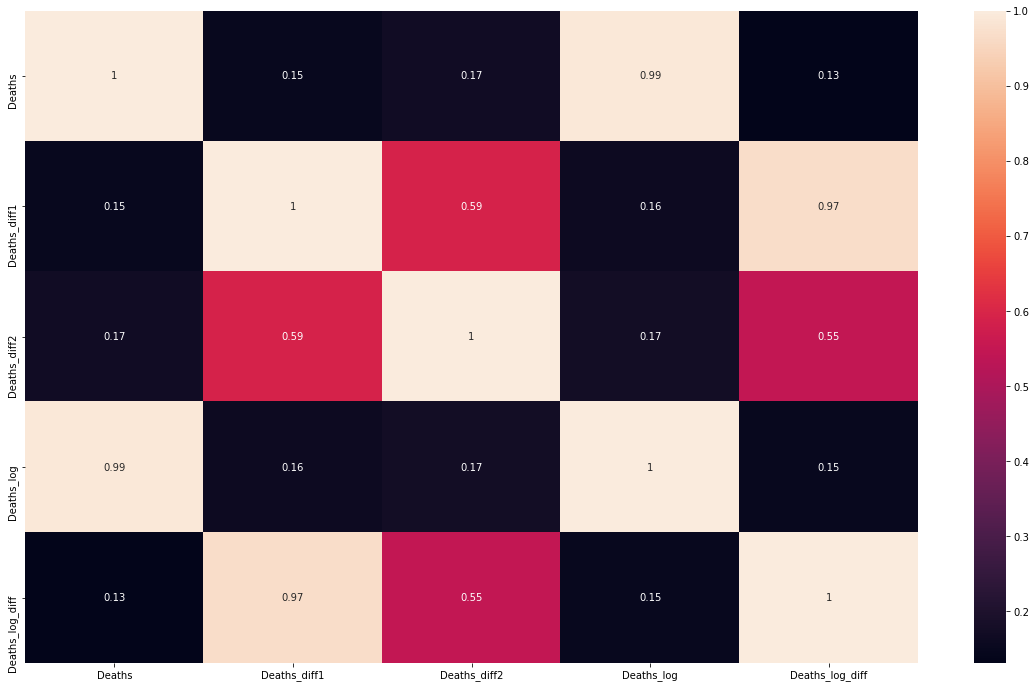

In [109]:
# check for correlation using heatmap
plt.rcParams['figure.figsize'] = 20,12
corr_ind = deaths.corr()
sns.heatmap(corr_ind,annot=True)
plt.show

##### Heat map clearly explains taht Death_log is highly correlated with actual Death

In [112]:
#apply adf test on the series for recovered after defferencing
adfuller_test(deaths.Deaths_log_diff)

ADF Test Statistic : -5.272590977362418
p-value : 6.238790901037088e-06
#Lags Used : 9
Number of Observations Used : 101
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [113]:
#Split the data
X=deaths.index
y=deaths.Deaths_log_diff
#X=recovered.values

predictions=[]

In [114]:
#split for traing and test data
train_size=int(len(deaths) *0.7)
test_size = int(len(deaths)) - train_size

train_X, train_y = X[:train_size], y[:train_size]
test_X, test_y = X[train_size:].dropna(), y[train_size:].dropna()

In [115]:
train_size

77

#### We will use the AIC (Akaike Information Criterion) value, which is conveniently returned with ARIMA models fitted using statsmodels. The AIC measures how well a model fits the data while taking into account the overall complexity of the model.

In [116]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
#for Confirmed 
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_y, 
                                            #exog= train_X,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 10)12 - AIC:-134.9158118982136
ARIMA(0, 0, 0)x(0, 0, 1, 10)12 - AIC:-115.28931426970105
ARIMA(0, 0, 0)x(0, 1, 0, 10)12 - AIC:-56.32778140927343
ARIMA(0, 0, 0)x(0, 1, 1, 10)12 - AIC:-89.44249048076693
ARIMA(0, 0, 0)x(1, 0, 0, 10)12 - AIC:-114.92813039932615
ARIMA(0, 0, 0)x(1, 0, 1, 10)12 - AIC:-115.792594387859
ARIMA(0, 0, 0)x(1, 1, 0, 10)12 - AIC:-63.166888670328646
ARIMA(0, 0, 0)x(1, 1, 1, 10)12 - AIC:-93.1633998678566
ARIMA(0, 0, 1)x(0, 0, 0, 10)12 - AIC:-141.81458204986333
ARIMA(0, 0, 1)x(0, 0, 1, 10)12 - AIC:-120.16276024001753
ARIMA(0, 0, 1)x(0, 1, 0, 10)12 - AIC:-61.362202820471055
ARIMA(0, 0, 1)x(0, 1, 1, 10)12 - AIC:-94.14678377318347
ARIMA(0, 0, 1)x(1, 0, 0, 10)12 - AIC:-121.30764207697496
ARIMA(0, 0, 1)x(1, 0, 1, 10)12 - AIC:-119.56428313933297
ARIMA(0, 0, 1)x(1, 1, 0, 10)12 - AIC:-68.25696642588265
ARIMA(0, 0, 1)x(1, 1, 1, 10)12 - AIC:-98.72450420316896
ARIMA(0, 1, 0)x(0, 0, 0, 10)12 - AIC:-55.939675801986965
ARIMA(0, 1, 0)x(0, 0, 1, 10)12 - AIC:-47.

In [117]:
model=sm.tsa.statespace.SARIMAX(deaths['Deaths_log_diff'],order=(0,1,1),seasonal_order=(1,0,1,20))
results=model.fit()

print(results.summary().tables[1]) 

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0000    884.850     -0.001      0.999   -1735.275    1733.275
ar.S.L20       0.8092      0.545      1.485      0.138      -0.259       1.877
ma.S.L20      -0.9946      9.424     -0.106      0.916     -19.465      17.475
sigma2         0.0077      6.819      0.001      0.999     -13.357      13.373


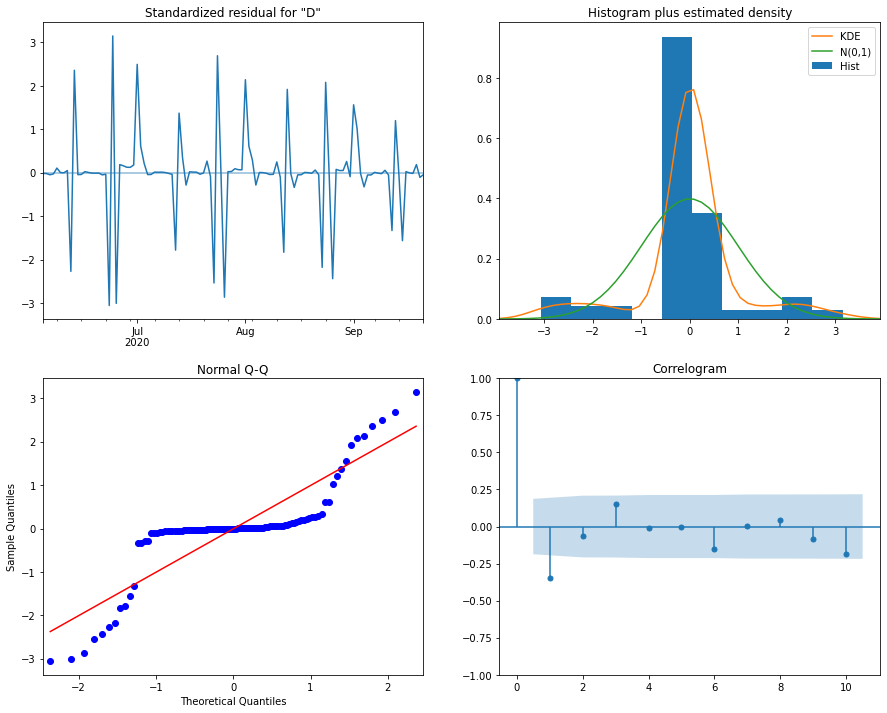

In [118]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

#### To determine the goodness of fit of the model, we can examine its residuals using the standard assumption: they should be normally distributed around 0, or in other words, white noise.

#### Our primary concern is to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean. If the seasonal ARIMA model does not satisfy these properties, it is a good indication that it can be further improved.

#### In this case, our model diagnostics suggests that the model residuals are  not normally distributed based on the following:

#### In the top right plot, we see that the red KDE line do not follow closely with the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). 
### This is a good indication that the residuals are normally distributed.

#### The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) do not follow the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are not very much normally distributed.
#### The residuals over time (top left plot) display any obvious seasonality and appear to be seasonal. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have high correlation with lagged versions of itself.

In [120]:
# forecast using the test set which is 30%
deaths['forecast']= results.predict(start=78,end=111,dynamic=True)


In [121]:
deaths

Deaths  Deaths_diff1  Deaths_diff2  Deaths_log  Deaths_log_diff  \
Date                                                                          
2020-06-03  199708        2678.0       23904.0   12.204612         0.013500   
2020-06-04  202014        2306.0        4984.0   12.216092         0.011481   
2020-06-05  204090        2076.0        4382.0   12.226316         0.010224   
2020-06-06  205454        1364.0        3440.0   12.232977         0.006661   
2020-06-07  206998        1544.0        2908.0   12.240464         0.007487   
...            ...           ...           ...         ...              ...   
2020-09-17  432492        2658.0        5903.0   12.977319         0.006165   
2020-09-18  434419        1927.0        4585.0   12.981765         0.004446   
2020-09-19  436277        1858.0        3785.0   12.986033         0.004268   
2020-09-20  438540        2263.0        4121.0   12.991206         0.005174   
2020-09-21  442168        3628.0        5891.0   12.999445         0.008239   

            forecast  
Date                  
2020-06-03       NaN  
2020-06-04       NaN  
2020-06-05       NaN  
2020-06-06       NaN  
2020-06-07       NaN  
...              ...  
2020-09-17  0.009527  
2020-09-18  0.009018  
2020-09-19 -0.007443  
2020-09-20  0.016325  
2020-09-21  0.032232  

[111 rows x 6 columns]

<AxesSubplot:xlabel='Date'>

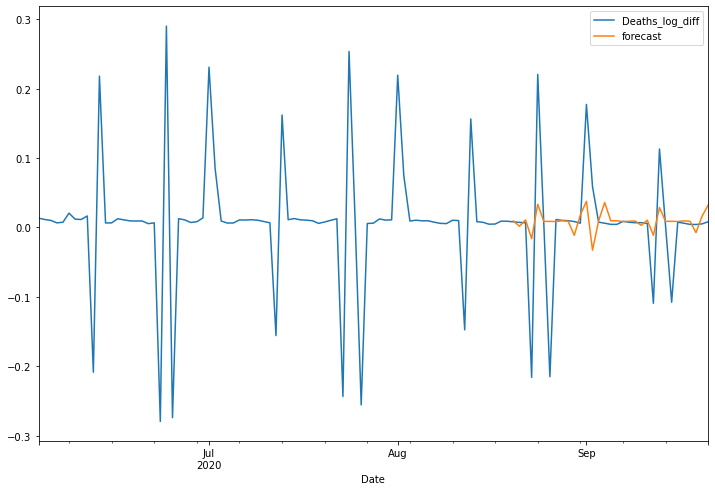

In [122]:
deaths[['Deaths_log_diff','forecast']].plot(figsize=(12,8))

In [123]:
deaths1=deaths.dropna()
deaths1.reset_index(inplace=True)

<AxesSubplot:>

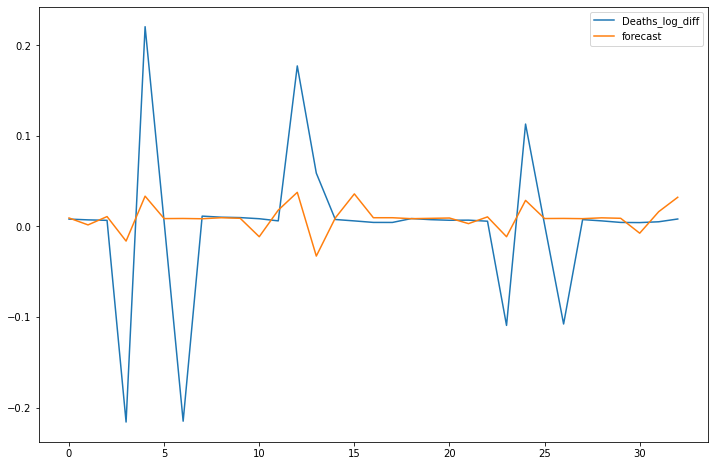

In [124]:
deaths1[['Deaths_log_diff','forecast']].plot(figsize=(12,8))

#### the graphs shows the difference in forecasted values and actual Deaths value
##### This shows the model is not very accurate , it has some error , below error parameters explains that very well

In [125]:
# Mean Square error
y_forecasted = deaths1['forecast']
y_truth = deaths1['Deaths_log_diff']

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.01


In [126]:
r2_score(deaths1['Deaths_log_diff'], deaths1['forecast'])

0.1311664691266582

In [127]:
mean_absolute_percentage_error(deaths1['Deaths_log_diff'], deaths1['forecast'])

1.1195168975586045

In [128]:
mean_absolute_error(deaths1['Deaths_log_diff'], deaths1['forecast'])

0.03965573321992405

#### MAE is more robust to data with outliers. in this case, there are very less outliers
#### The lower value of MAE, MSE implies higher accuracy of a regression model. in above case MSE and MAE values are very less. this implies the model is very much accurate.
#### R Squared is used for explaining how well the independent variables in the regression model explains the variability in the dependent variable . so in above case we can infer that the independent variables are very much varied with respect to dependent variable

In [129]:
# forecast for next 17 days
futureForecast= results.predict(start=110,end=127,dynamic=True)

In [130]:
futureForecast.index.name = 'Dates'
futureForecast

Dates
2020-09-21    0.012389
2020-09-22   -0.038731
2020-09-23    0.006719
2020-09-24    0.031601
2020-09-25    0.007308
2020-09-26    0.007309
2020-09-27    0.005816
2020-09-28    0.006300
2020-09-29    0.006852
2020-09-30    0.000328
2020-10-01    0.008319
2020-10-02    0.024607
2020-10-03   -0.009943
2020-10-04    0.007031
2020-10-05    0.046037
2020-10-06    0.005457
2020-10-07    0.006755
2020-10-08    0.006474
Freq: D, Name: predicted_mean, dtype: float64

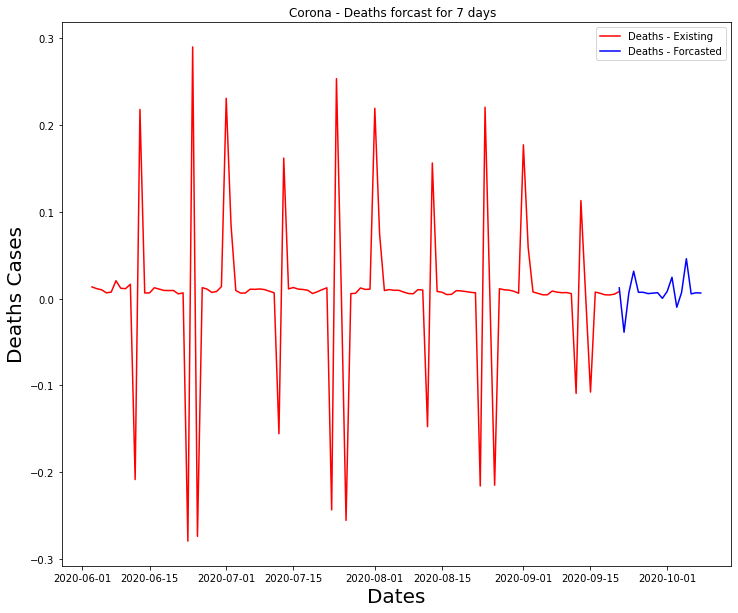

In [131]:
plt.figure(figsize=(12,10))
plt.xticks( fontsize= 10)
plt.xlabel('Dates').set_size(20)
plt.ylabel('Deaths Cases').set_size(20)
plt.title('Corona - Deaths forcast for 7 days  ')
plt.yticks(fontsize =10)
plt.plot(deaths.Deaths_log_diff,'red',label='Deaths - Existing')
plt.plot(futureForecast,'blue',label='Deaths - Forcasted')
plt.legend()

# Conclusion

### After analysing our data with 2 completely different models 1. Fbprophet and 2.SARIMA, we can conclude that the data set fits the model very well. We have done a good decision on selecting the right model for our prediction 
#### 1. Form both models we see MAE and MSE scores are very less means error handeling is done very well .
#### 2. Future prediction(next 7 Days) done in both the models is very close to the reality and we can relay on this prediction to predict any number of days for any country.
#### 3. On weekly plot analysis sunday and monday is having lower number of confirmed cases. This is beacuse sunday is a holiday so maybe there will be less tests happening and there can be a case due to lockdown in some countries Sunday people may get less infected as they all stay at home. 
#### 4. With the same weekly plot we see there is a steady increase in the number of recovered cases. This is also a good sign of improvement
#### 5. With the weekly data it is observed that monday and friday is having higher number of death cases. 

### Over all we can say Recovery of covid cases is directly proportion to Confirmed covid cases and Deaths case on very proportion as recovery, but be have work towords making it inversly proportional to confirmed.
### By doing this, we can save many people lifes which is very precious.


####  Below are forecast values for Recovered dataset for next 7 days
#### Dates         
##### 2020-09-22    16.318971

##### 2020-09-23    16.329862

##### 2020-09-24    16.339867

##### 2020-09-25    16.350189

##### 2020-09-26    16.364652

##### 2020-09-27    16.374715

##### 2020-09-28    16.386098

#### Below are forecastt values for Death dataset for next 7 days.
#### Dates

2020-09-22 - 462633.234400

2020-09-23 - 466714.454199

2020-09-24 - 465105.636591

2020-09-25 - 474313.460687

2020-09-26 - 473848.851956

2020-09-27 - 471295.036041

2020-09-28 - 482558.485949


#                                          THANK YOU